In [1]:
import numpy as np
import pandas as pd
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
# from aisynphys.connectivity import measure_connectivity, pair_was_probed, GaussianModel, recip_connectivity_profile
# from aisynphys.ui.notebook import show_connectivity_profile, show_distance_binned_cp, show_connectivity_raster, set_distance_xticks 
# from aisynphys.ui.notebook import cell_class_matrix, ei_hist_plot, plot_metric_pairs, metric_stats, compose_svg_figure
import aisynphys.connectivity as conn
import aisynphys.ui.notebook as nb
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline
plt.rcParams["font.sans-serif"] = "Arial"

In [2]:
session = db.session()
print(db.schema_version)

21


In [3]:
# fix slow autocomplete
%config Completer.use_jedi = False

# Connection probability

In [4]:
projects = [
    'human coarse matrix', 
#     'human patch-seq',
]
human_pairs = db.pair_query(project_name=projects).all()
print("loaded %d cell pairs" % len(human_pairs))

loaded 10400 cell pairs


### Connectivity-distance profiles

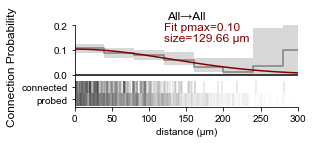

In [5]:
all_type = CellClass(name="All")
all_connectivity = conn.measure_connectivity({(all_type, all_type): human_pairs}, 
                                        fit_model=conn.GaussianModel, dist_measure='lateral_distance')

pair_class, results = list(all_connectivity.items())[0]

fig, ax = plt.subplots(figsize=(4,1.5))
dist = results['probed_distances']
dist_conn = results['connected_distances']
fit = results['connectivity_fit']
nb.show_connectivity_profile(dist, dist_conn, ax, fit, ymax=0.5)
ax.set_ylabel('Connection Probability', fontsize=12)
label = ( "Fit pmax=%0.2f\nsize=%0.2f µm" % (fit.pmax, fit.size*1e6))
ax.text(0.4, 0.8, label, transform=ax.transAxes, color=(0.5, 0, 0), horizontalalignment='left', fontsize=12)
ax.set_title("%s→%s" % (pair_class[0], pair_class[1]), fontsize=12)
ax.set_xlim(0, 300e-6)
ax.set_ylim(None, 0.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
supp_sigma = fig

We'll use this value as the standard correction for all matrices

In [6]:
sigma_human=130e-6

### Connection probability matrix

In [7]:
import matplotlib
# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')
def plot_cp_matrix(cell_classes, dist_measure=None, correction_model=None, sigma=sigma_human):
    # Group all cells by selected classes
    cell_groups = classify_cells(cell_classes.values(), pairs=human_pairs, missing_attr='ignore')

    # Group pairs into (pre_class, post_class) groups
    pair_groups = classify_pairs(human_pairs, cell_groups)

    # analyze matrix elements
    kwargs = dict(sigma=sigma_human, dist_measure=dist_measure) if dist_measure else {}
    connectivity_results = conn.measure_connectivity(pair_groups, fit_model=conn.GaussianModel, 
                                                correction_model=correction_model, **kwargs)

    # define the display labels to use for each cell subclass:
    class_labels = {key: key for key in cell_classes.keys()}

    # create a figure/axes to draw on
    size = 0.8*len(cell_classes)
    conn_fig, ax = plt.subplots(figsize=(size,size))

    # finally, draw the colormap using the provided function:
    im, cbar, labels = nb.show_connectivity_matrix(
        ax=ax, 
        results=connectivity_results, 
        pre_cell_classes=cell_classes.values(), 
        post_cell_classes=cell_classes.values(), 
        class_labels=class_labels,
        cmap=cmap, 
        norm=norm,
        ctype='chemical',
        distance_adjusted=dist_measure is not None,
        corrections_applied=correction_model is not None,
        alpha=True,
        layer_lines=[5.5], 
    )
    ax.set_ylabel(ax.get_ylabel(), size=12)
    ax.set_xlabel(ax.get_xlabel(), size=12)
    return conn_fig, connectivity_results

In [8]:
from aisynphys.ui.notebook import heatmap

def matrix_show(ax, results, pre_cell_classes, post_cell_classes, class_labels, cmap, norm, ctype='chemical', 
                distance_adjusted=False, corrections_applied=False,
                cbarlabel='Connection Probability', layer_lines=None, alpha=True):
    shape = (len(pre_cell_classes), len(post_cell_classes))
    cprob = np.zeros(shape)
    cprob_alpha = np.zeros(shape)
    cprob_str = np.zeros(shape, dtype=object)

    for i,pre_class in enumerate(pre_cell_classes):
        for j,post_class in enumerate(post_cell_classes):
            result = results[pre_class, post_class]
            if ctype == 'chemical':
                found = result['n_connected']
                if distance_adjusted:
                    cp, cp_lower_ci, cp_upper_ci = result['adjusted_connectivity']
                elif corrections_applied:
                    cp, cp_lower_ci, cp_upper_ci = result['connectivity_correction_fit'].cp_ci
                else:
                    cp, cp_lower_ci, cp_upper_ci = result['connection_probability']
            elif ctype == 'electrical':
                found = result['n_gaps']
                if distance_adjusted:
                    raise Exception('Distance adjustment for gap junctions not yet available')
                else:
                    cp, cp_lower_ci, cp_upper_ci = result['gap_probability']
            else:
                raise Exception('ctype must be one of "chemical" or "electrical"')
            cp_upper_ci = min(1, cp_upper_ci)
            cp_lower_ci = max(0, cp_lower_ci)
            cprob[i,j] = cp
#             cprob_str[i,j] = "" if result['n_probed'] == 0 else "%d/%d" % (found, result['n_probed'])
            cprob_alpha[i,j] = 1.0 - 1.5 * max(cp_upper_ci - cp, cp - cp_lower_ci)
            
            conn_str = "" if result['n_probed'] == 0 else "%d" % (found) 
            prob_str = "" if result['n_probed'] == 0 else "%d" % (result['n_probed'])
            cp_str = "" if result['n_probed'] == 0 else "%.2f" % (cp)
            ci_upper_str = "" if result['n_probed'] == 0 else "%.2f" % (cp_upper_ci)
            ci_lower_str = "" if result['n_probed'] == 0 else "%.2f" % (cp_lower_ci)
            cprob_str[i, j] = (cp_str, conn_str, prob_str, ci_upper_str, ci_lower_str)

    # map connection probability to RGB colors
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    cprob_rgba = mapper.to_rgba(np.clip(cprob, 0.01, 1.0))

    # apply alpha based on confidence intervals
#     if alpha:
    cprob_rgba[:, :, 3] = np.clip(cprob_alpha, 0, 1)

    # generate lists of labels to display along the pre- and postsynaptic axes
    pre_class_labels = [class_labels[cls] for cls in pre_cell_classes]
    post_class_labels = [class_labels[cls] for cls in post_cell_classes]

    # draw the heatmap with axis labels and colorbar
    im, cbar = heatmap(cprob_rgba, pre_class_labels, post_class_labels, ax=ax, 
        ax_labels=('postsynaptic', 'presynaptic'),
        bg_color=(0.7, 0.7, 0.7),
        cmap=cmap, norm=norm, 
        cbarlabel=cbarlabel, 
        cbar_kw={'shrink':0.5})
    
    if layer_lines is not None:
        [ax.axhline(pos, color='white', linewidth=2) for pos in layer_lines]
        [ax.axvline(pos, color='white', linewidth=2) for pos in layer_lines]

    return im, cprob_str, cprob

def annotate(im, labels, data=None, textcolors=("black", "white"),
                     threshold=None, **textkw):
    pixels, _, _, _ = im.make_image(renderer=None, unsampled=True)

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center", fontsize=16)
    kw.update(textkw)
    
    width, height = np.shape(labels)
    k = 2.5
    pixel_width = 1/width*k
    pixel_height = 1/height*k

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            px_color = pixels[i,j]
            if isinstance(px_color, np.ma.core.MaskedArray):
                px_color = px_color.data
            color = textcolors[int(np.mean(px_color[:3]) < 128)]
            kw['color'] =  textcolors[int(np.mean(px_color[:3]) < 128)]
            cp, conn, prob, upper, lower = labels[i, j]
            im.axes.text(j, i, cp, **kw)
            im.axes.text(j-pixel_width, i-pixel_height, conn, dict(ha='left', va='top', color=color))
            im.axes.text(j-pixel_width, i+pixel_height, prob, dict(ha='left', va='bottom', color=color))
            im.axes.text(j+pixel_width, i-pixel_height, upper, dict(ha='right', va='top', color=color))
            im.axes.text(j+pixel_width, i+pixel_height, lower, dict(ha='right', va='bottom', color=color))
#             texts.append(text)
    return pixels

In [9]:
combined_cell_classes = {
    'L2 Pyr': CellClass(dendrite_type='spiny', name='L2 Pyr', **{'cortical_layer':'2'}),
    'L3a Pyr': CellClass(db.CorticalCellLocation.fractional_layer_depth < 0.5, 
                         dendrite_type='spiny', name='L3a Pyr', **{'cortical_layer':'3'}),
    'L3b Pyr': CellClass(db.CorticalCellLocation.fractional_layer_depth > 0.5, 
                         dendrite_type='spiny', name='L3b Pyr', **{'cortical_layer':'3'}),
    'L4 Pyr': CellClass(dendrite_type='spiny', name='L4 Pyr', **{'cortical_layer':'4'}),
    'L5 Pyr': CellClass(dendrite_type='spiny', name='L5 Pyr', **{'cortical_layer':'5'}),
    'Inh':    CellClass(cell_class_nonsynaptic='in', name='Inh', ),  # aspiny or sparsely spiny
}

In [10]:
# fig_a, connectivity_results = plot_cp_matrix(combined_cell_classes, dist_measure='lateral_distance')

# fig = plt.figure(figsize=(8,8))
# ax = fig.add_axes([0,0,1,1])
# cell_classes = combined_cell_classes
# class_labels = {key: key for key in cell_classes.keys()}
# im, cprob_str, cprob = matrix_show(
#     ax=ax, 
#     results=connectivity_results, 
#     pre_cell_classes=cell_classes.values(), 
#     post_cell_classes=cell_classes.values(), 
#     class_labels=class_labels,
#     cmap=cmap, 
#     norm=norm,
#     ctype='chemical',
#     distance_adjusted=True, 
# #     layer_lines=[5.5],
# )

# pixels = annotate(im, cprob_str, data=cprob)

### Correction model

/home/tom.chartrand/work/aisynphys/aisynphys/connectivity.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(p[conn]).sum() + np.log((1-p)[~conn]).sum()


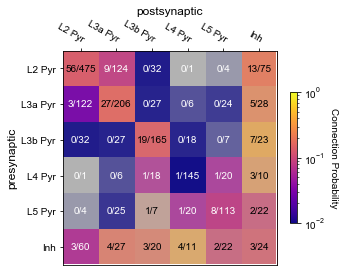

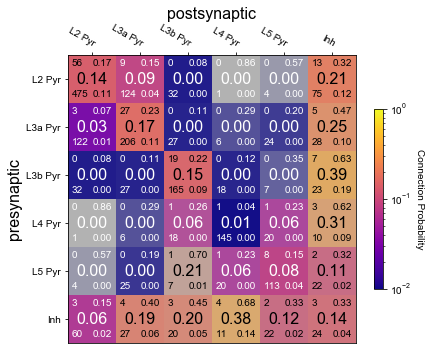

In [11]:
correction_parameters = [[0.1, sigma_human]]
corr_model = conn.CorrectionModel(0.1, ['lateral_distance'], [conn.GaussianModel.correction_func], correction_parameters)

fig_a_new, connectivity_results2 = plot_cp_matrix(combined_cell_classes, correction_model=corr_model)

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
cell_classes = combined_cell_classes
class_labels = {key: key for key in cell_classes.keys()}
im, cprob_str, cprob = matrix_show(
    ax=ax, 
    results=connectivity_results2, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels,
    cmap=cmap, 
    norm=norm,
    ctype='chemical',
    distance_adjusted=False,
    corrections_applied=True
)
supp_matrix = fig
pixels = annotate(im, cprob_str, data=cprob)
fig.savefig('human_detailed_matrix.png', dpi=300)
fig.savefig('human_detailed_matrix.svg', dpi=300)

# Connection property matrices

In [12]:
cell_class_criteria = {
    'L2 Exc': {'cell_class': 'ex', 'cortical_layer': '2'},
    'L3 Exc': {'cell_class': 'ex', 'cortical_layer': '3'},
    'L5 Exc': {'cell_class': 'ex', 'cortical_layer': '5'},
    'Inh':    {'cell_class': 'in'},  
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}
class_labels = {key: key for key in cell_classes.keys()}

ei_classes = {'ex': CellClass(cell_class='ex'), 'in': CellClass(cell_class='in')}

pair_query_args = {
    'project_name': ['human coarse matrix', 
#                      'human patch-seq'
                    ],
    'species': 'human',
    'synapse': True,
    'filter_exprs': [db.Synapse.latency < 3e-3]
}
mouse_pair_query_args = {
            'synapse':True,
        'project_name': ['mouse V1 pre-production', 'mouse V1 coarse matrix'],
}

In [13]:
from importlib import reload
reload(nb)

<module 'aisynphys.ui.notebook' from '/home/tom.chartrand/work/aisynphys/aisynphys/ui/notebook.py'>

/local1/storage/envs/synphys/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/local1/storage/envs/synphys/lib/python3.7/site-packages/matplotlib/colors.py:1108: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)


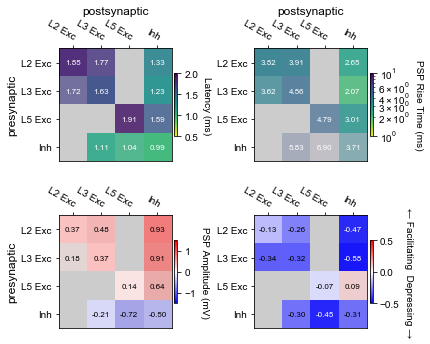

In [14]:
fig_b, axs = plt.subplots(2,2, figsize=(6,5))
axs = axs.ravel()
nb.cell_class_matrix(cell_classes, cell_classes, 'latency', class_labels, ax=axs[0], 
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
nb.cell_class_matrix(cell_classes, cell_classes, 'psp_rise_time', class_labels, ax=axs[1], 
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
nb.cell_class_matrix(cell_classes, cell_classes, 'psp_amplitude', class_labels, ax=axs[2], 
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
nb.cell_class_matrix(cell_classes, cell_classes, 'stp_induction_50hz', class_labels, ax=axs[3], 
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
for ax in axs:
    ax.set_ylabel(ax.get_ylabel(), size=12)
    ax.set_xlabel(ax.get_xlabel(), size=12)
for i in [2,3,]:
    axs[i].set_xlabel(None)
for i in [1,3,]:
    axs[i].set_ylabel(None)
    
fig_b.tight_layout()
plt.show()

### E/I histogram plots

In [15]:
metric = 'latency'
df = nb.get_metric_data(metric, db, ei_classes, ei_classes, pair_query_args=pair_query_args)[0]
a = df.query("pre_class=='ex' & post_class=='ex'")[metric]*1e3
b = df.query("pre_class=='in' & post_class=='ex'")[metric]*1e3
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.3g} [{a.quantile(0.25):.3g} {a.quantile(0.75):.3g}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.2g}")

1.73 [1.41 2.23]
1.06 [0.86 1.57]
ks=6.9e-06


In [16]:
b = df.query("pre_class=='ex' & post_class=='in'")[metric]*1e3
ks = nb.stats.ks_2samp(a, b)
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

1.34 [1.14 1.70]
ks=2.4e-03


In [17]:
metric = 'psp_rise_time'
df = nb.get_metric_data(metric, db, ei_classes, ei_classes, pair_query_args=pair_query_args)[0]
a = df.query("pre_class=='ex' & post_class=='ex'")[metric]*1e3
b = df.query("pre_class=='ex' & post_class=='in'")[metric]*1e3
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.2f} [{a.quantile(0.25):.2f} {a.quantile(0.75):.2f}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

4.10 [3.14 5.52]
2.48 [1.63 2.98]
ks=7.0e-08


In [18]:
c = df.query("pre_class=='in' & post_class=='ex'")[metric]*1e3
print(f"{c.median():.2f} [{c.quantile(0.25):.2f} {c.quantile(0.75):.2f}]")
ks = nb.stats.ks_2samp(a, c)
print(f"ks={ks.pvalue:.1e}")
ks = nb.stats.ks_2samp(b, c)
print(f"ks={ks.pvalue:.1e}")

5.83 [4.52 7.41]
ks=9.1e-03
ks=2.3e-05


In [19]:
metric = 'stp_induction_50hz'
all_classes = dict(all=CellClass())
df = nb.get_metric_data(metric, db, pre_classes=cell_classes, post_classes=all_classes, pair_query_args=pair_query_args)[0]
a = df.query("pre_class=='L3 Exc' & post_class=='all'")[metric]
b = df.query("pre_class=='L2 Exc' & post_class=='all'")[metric]
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.2f} [{a.quantile(0.25):.2f} {a.quantile(0.75):.2f}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

-0.34 [-0.61 -0.13]
-0.15 [-0.42 -0.01]
ks=1.1e-02


In [20]:
metric = 'psp_amplitude'
classes = {'ex': CellClass(cell_class='ex', cortical_layer=('2','3')), 
           'in': CellClass(cell_class='in', cortical_layer=('2','3'))}
dfh = nb.get_metric_data(metric, db, pre_classes=classes, post_classes=classes, pair_query_args=pair_query_args)[0]
classes = {'ex': CellClass(cell_class='ex', cortical_layer=('2/3')), 
           'in': CellClass(cell_class='in', cortical_layer=('2/3'))}
dfm = nb.get_metric_data(metric, db, pre_classes=classes, post_classes=classes, pair_query_args=mouse_pair_query_args)[0]
a = dfh.query("pre_class=='ex' & post_class=='ex'")[metric]*1e3
b = dfm.query("pre_class=='ex' & post_class=='ex'")[metric]*1e3
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.2f} [{a.quantile(0.25):.2f} {a.quantile(0.75):.2f}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

0.37 [0.14 0.65]
0.17 [0.08 0.41]
ks=1.8e-01


In [21]:
a = dfh.query("pre_class=='ex' & post_class=='in'")[metric]*1e3
b = dfm.query("pre_class=='ex' & post_class=='in'")[metric]*1e3
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.2f} [{a.quantile(0.25):.2f} {a.quantile(0.75):.2f}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

0.92 [0.34 1.61]
0.26 [0.09 0.58]
ks=1.1e-03


In [22]:
metric = 'pulse_amp_90th_percentile'
classes = {'ex': CellClass(cell_class='ex', cortical_layer=('2','3')), 
           'in': CellClass(cell_class='in', cortical_layer=('2','3'))}
dfh = nb.get_metric_data(metric, db, pre_classes=classes, post_classes=classes, pair_query_args=pair_query_args)[0]
classes = {'ex': CellClass(cell_class='ex', cortical_layer=('2/3')), 
           'in': CellClass(cell_class='in', cortical_layer=('2/3'))}
dfm = nb.get_metric_data(metric, db, pre_classes=classes, post_classes=classes, pair_query_args=mouse_pair_query_args)[0]
a = dfh.query("pre_class=='ex' & post_class=='ex'")[metric]*1e3
b = dfm.query("pre_class=='ex' & post_class=='ex'")[metric]*1e3
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.2f} [{a.quantile(0.25):.2f} {a.quantile(0.75):.2f}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

0.51 [0.30 0.96]
0.29 [0.26 0.66]
ks=3.6e-02


In [23]:
a = dfh.query("pre_class=='ex' & post_class=='in'")[metric]*1e3
b = dfm.query("pre_class=='ex' & post_class=='in'")[metric]*1e3
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.2f} [{a.quantile(0.25):.2f} {a.quantile(0.75):.2f}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

1.11 [0.78 2.12]
0.87 [0.56 1.77]
ks=3.5e-01


In [24]:
metric = 'stp_induction_50hz'
classes = {'ex': CellClass(cell_class='ex', cortical_layer=('2','3')), 
           'in': CellClass(cell_class='in', cortical_layer=('2','3'))}
dfh = nb.get_metric_data(metric, db, pre_classes=classes, post_classes=classes, pair_query_args=pair_query_args)[0]
classes = {'ex': CellClass(cell_class='ex', cortical_layer=('2/3')), 
           'in': CellClass(cell_class='in', cortical_layer=('2/3'))}
dfm = nb.get_metric_data(metric, db, pre_classes=classes, post_classes=classes, pair_query_args=mouse_pair_query_args)[0]
a = dfh.query("pre_class=='ex' & post_class=='in'")[metric]
b = dfm.query("pre_class=='ex' & post_class=='in'")[metric]
ks = nb.stats.ks_2samp(a, b)
print(f"{a.median():.2f} [{a.quantile(0.25):.2f} {a.quantile(0.75):.2f}]")
print(f"{b.median():.2f} [{b.quantile(0.25):.2f} {b.quantile(0.75):.2f}]")
print(f"ks={ks.pvalue:.1e}")

-0.56 [-0.83 -0.07]
0.06 [-0.06 0.18]
ks=1.5e-05


In [25]:
q = db.pair_query(pre_class=CellClass(cell_class='ex', cortical_layer=('2','3')),
                  post_class=CellClass(cell_class='in', cortical_layer=('2','3')),
                  **pair_query_args)
q = q.join(db.PulseResponse).join(db.PulseResponseFit)
q = q.filter(db.PulseResponse.ex_qc_pass==True)
q = q.add_column(db.PulseResponse.pair_id).add_column(db.PulseResponseFit.fit_amp)
q = q.order_by(db.PulseResponseFit.fit_amp.desc())
amp_pairs = q.limit(5).dataframe()
amp_pairs

pair.id  pair.experiment_id  pair.pre_cell_id  pair.post_cell_id  \
0    57270                1678              9969               9964   
1    98528                3130             17833              17830   
2    44135                1278              7589               7590   
3    98528                3130             17833              17830   
4    92588                2900             16670              16672   

  pair.has_synapse pair.has_polysynapse pair.has_electrical  \
0             True                False               False   
1             True                False               False   
2             True                False               False   
3             True                False               False   
4             True                False               False   

   pair.crosstalk_artifact  pair.n_ex_test_spikes  pair.n_in_test_spikes  \
0                      NaN                    772                     59   
1                      NaN                    567                      0   
2                      NaN                    885                     86   
3                      NaN                    567                      0   
4                      NaN                    656                    131   

   pair.distance  pair.lateral_distance  pair.vertical_distance  \
0       0.000129               0.000103                0.000024   
1       0.000163               0.000011                0.000127   
2       0.000044               0.000027                0.000030   
3       0.000163               0.000011                0.000127   
4       0.000030               0.000019                0.000010   

   pair.reciprocal_id pair.meta  pulse_response.pair_id  \
0               57239      None                   57270   
1               98509      None                   98528   
2               44146      None                   44135   
3               98509      None                   98528   
4               92602      None                   92588   

   pulse_response_fit.fit_amp  
0                    0.012542  
1                    0.011261  
2                    0.010930  
3                    0.010077  
4                    0.010015

In [26]:
q = db.pair_query(pre_class=CellClass(cell_class='ex', cortical_layer=('2/3')), 
                  post_class=CellClass(cell_class='in', cortical_layer=('2/3')),
                  **mouse_pair_query_args)
q = q.join(db.PulseResponse).join(db.PulseResponseFit)
q = q.filter(db.PulseResponse.ex_qc_pass==True)
q = q.add_column(db.PulseResponse.pair_id).add_column(db.PulseResponseFit.fit_amp)
q = q.order_by(db.PulseResponseFit.fit_amp.desc())
amp_pairs = q.limit(5).dataframe()
amp_pairs

pair.id  pair.experiment_id  pair.pre_cell_id  pair.post_cell_id  \
0    92346                2894             16630              16629   
1    92346                2894             16630              16629   
2    92346                2894             16630              16629   
3    92346                2894             16630              16629   
4    63063                1873             11057              11049   

  pair.has_synapse pair.has_polysynapse pair.has_electrical  \
0             True                False               False   
1             True                False               False   
2             True                False               False   
3             True                False               False   
4             True                False               False   

   pair.crosstalk_artifact  pair.n_ex_test_spikes  pair.n_in_test_spikes  \
0                      NaN                    620                    524   
1                      NaN                    620                    524   
2                      NaN                    620                    524   
3                      NaN                    620                    524   
4                      NaN                   1001                    283   

   pair.distance  pair.lateral_distance  pair.vertical_distance  \
0       0.000055               0.000023                0.000041   
1       0.000055               0.000023                0.000041   
2       0.000055               0.000023                0.000041   
3       0.000055               0.000023                0.000041   
4       0.000139               0.000119                0.000025   

   pair.reciprocal_id pair.meta  pulse_response.pair_id  \
0               92339      None                   92346   
1               92339      None                   92346   
2               92339      None                   92346   
3               92339      None                   92346   
4               63043      None                   63063   

   pulse_response_fit.fit_amp  
0                    0.014502  
1                    0.013266  
2                    0.012865  
3                    0.012778  
4                    0.012721

In [27]:
def ei_hist_plot(metric, bin_edges, db, pair_query_args):
    fig, ax = plt.subplots(figsize=(4,3))
    ei_classes = {'ex': CellClass(cell_class='ex'), 'in': CellClass(cell_class='in')}
    
    pairs_has_metric, metric_name, units, scale, _, _, _, _, _ = nb.get_metric_data(metric, db, ei_classes, ei_classes, pair_query_args=pair_query_args)
    ex_pairs = pairs_has_metric[pairs_has_metric['pre_class']=='ex']
    if 'amp' in metric:
        ax.hist(ex_pairs[metric]*scale, bins=bin_edges, color=(0.8, 0.8, 0.8), label='All Excitatory Synapses')
    else:
        ax.hist(pairs_has_metric[metric]*scale, bins=bin_edges, color=(0.8, 0.8, 0.8), label='All Synapses')

    ee_pairs = ex_pairs[ex_pairs['post_class']=='ex']
    ei_pairs = ex_pairs[ex_pairs['post_class']=='in']
    ax.hist(ee_pairs[metric]*scale, bins=bin_edges, color='red', alpha=0.6, label='E->E Synapses')
    ax.hist(ei_pairs[metric]*scale, bins=bin_edges, color='pink', alpha=0.8, label='E->I Synapses')
    ax.legend(frameon=False)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('%s (%s)' % (metric_name, units))
    ax.set_ylabel('Number of Synapses', fontsize=12)

    #KS test
    excitatory = nb.stats.ks_2samp(ee_pairs[metric], ei_pairs[metric])
    print('Two-sample KS test for %s' % metric)
    print('Excitatory: p = %0.3e' % excitatory[1])

Two-sample KS test for latency
Excitatory: p = 2.404e-03


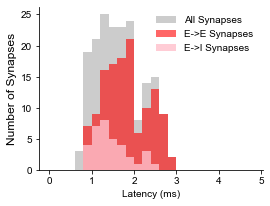

In [28]:
bin_edges = np.arange(0, 5, 0.2)
ei_hist_plot('latency', bin_edges, db, pair_query_args)

Two-sample KS test for psp_rise_time
Excitatory: p = 7.026e-08


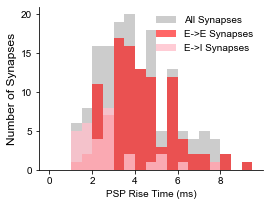

In [29]:
bin_edges = np.arange(0, 10, 0.5)
ei_hist_plot('psp_rise_time', bin_edges, db, pair_query_args)

Two-sample KS test for psp_amplitude
Excitatory: p = 1.475e-03


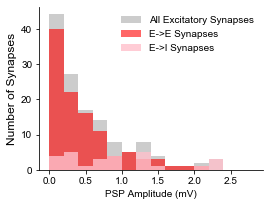

In [30]:
bin_edges = np.arange(0, 3, 0.2)
ei_hist_plot( 'psp_amplitude', bin_edges, db, pair_query_args=pair_query_args)

Two-sample KS test for pulse_amp_90th_percentile
Excitatory: p = 6.544e-04


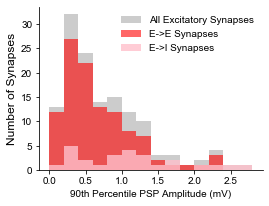

In [31]:
bin_edges = np.arange(0, 3, 0.2)
ei_hist_plot( 'pulse_amp_90th_percentile', bin_edges, db, pair_query_args=pair_query_args)

## Additional PSP/C response matrices

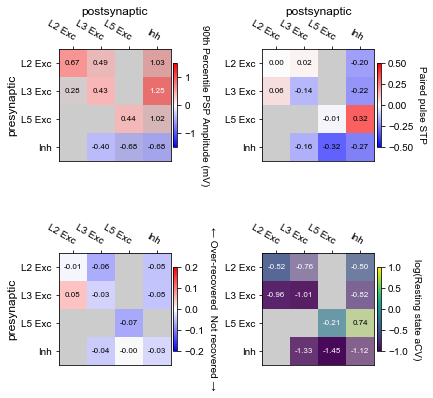

In [32]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs = axs.ravel()
nb.cell_class_matrix(cell_classes, cell_classes, 'pulse_amp_90th_percentile', class_labels, ax=axs[0],
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
nb.cell_class_matrix(cell_classes, cell_classes, 'stp_initial_50hz', class_labels, ax=axs[1], 
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
nb.cell_class_matrix(cell_classes, cell_classes, 'stp_recovery_250ms', class_labels, ax=axs[2], 
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
nb.cell_class_matrix(cell_classes, cell_classes, 'variability_resting_state', class_labels, ax=axs[3], 
                  db=db, pair_query_args=pair_query_args, estimator=np.median)
for ax in axs:
    ax.set_ylabel(ax.get_ylabel(), size=12)
    ax.set_xlabel(ax.get_xlabel(), size=12)
for i in [2,3,]:
    axs[i].set_xlabel(None)
for i in [1,3,]:
    axs[i].set_ylabel(None)
fig.tight_layout()
plt.show()
supp_matrices = fig

# STP details

In [33]:
cell_class_criteria = {
    'l2pyr': {'cell_class': 'ex', 'cortical_layer': '2'}, 
    'l3pyr': {'cell_class': 'ex', 'cortical_layer': '3'}, 
    'l23pyr': {'cell_class': 'ex', 'cortical_layer': ('2','3')}, 
    'l5pyr': {'cell_class': 'ex', 'cortical_layer': '5'}, 
    'inh': {'cell_class': 'in', }, 
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

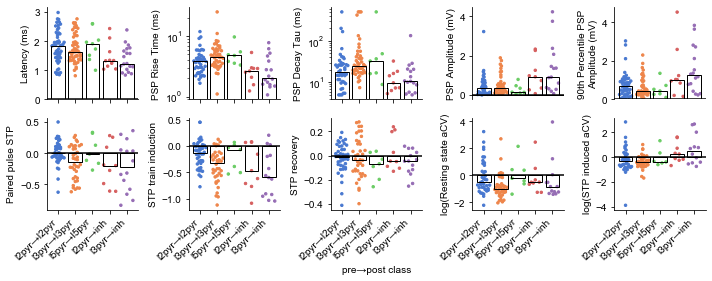

In [34]:
pair_class_list = [
    ('l2pyr', 'l2pyr'),
    ('l3pyr', 'l3pyr'),
    ('l5pyr', 'l5pyr'),
    ('l2pyr', 'inh'),
    ('l3pyr', 'inh'),
#     ('inh', 'l2pyr'),  
]
pair_classes = [(cell_classes[pre], cell_classes[post]) for pre, post in pair_class_list]

metrics = [ 
    'latency',
    'psp_rise_time',
    'psp_decay_tau',
    'psp_amplitude',
    'pulse_amp_90th_percentile',

    'stp_initial_50hz',
    'stp_induction_50hz',
    'stp_recovery_250ms',
    'variability_resting_state',
    'variability_stp_induced_state_50hz'
]

supp_swarms, ax = plt.subplots(2,5, figsize=(10,4))
ax = ax.ravel()
nb.pair_class_metric_scatter(metrics, db, pair_classes, pair_query_args, ax, palette='muted', estimator=np.median, 
                             plot_args=dict(s=6))
[a.axhline(0, color='k') for a in ax]
for i in range(5,10):
    ax[i].set_xticklabels(ax[-1].get_xticklabels(), rotation=45, horizontalalignment='right')
ax[7].set_xlabel(ax[-1].get_xlabel())
ax[-1].set_xlabel(None)
ax[5+1].set_ylabel('STP train induction')
ax[5+2].set_ylabel('STP recovery')
ax[5+3].set_ylabel('log(Resting state aCV)')
plt.tight_layout()

In [35]:
pair_class_list = [
    ('l2pyr', 'l2pyr'),
    ('l3pyr', 'l3pyr'),
    ('l5pyr', 'l5pyr'),
    ('l23pyr', 'inh'), 
]
pair_classes = [(cell_classes[pre], cell_classes[post]) for pre, post in pair_class_list]

from aisynphys.dynamics import stp_all_stim_to_df, stim_sorted_pulse_amp

stp_df = pd.DataFrame()
for pre, post in pair_class_list:
    pre_class = cell_classes[pre]
    post_class = cell_classes[post]
    pairs = db.pair_query(pre_class=pre_class, post_class=post_class, **pair_query_args).all()
    pair_data = {'pre_class': pre_class.name,  'post_class': post_class.name, 'pair_class': '%s->%s' % (pre_class.name, post_class.name)}
    stp_df = stp_all_stim_to_df(pairs, stp_df=stp_df, pair_data=pair_data)

stp_df['rec_delay']*=1e3   
pair_class_str = ['%s->%s'%(pc[0], pc[1]) for pc in pair_class_list]
interesting_classes = stp_df[stp_df['pair_class'].isin(pair_class_str)]
interesting_classes = interesting_classes[interesting_classes['ind_freq'] < 200]

[None, None]

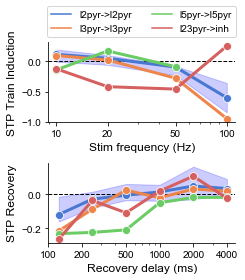

In [36]:
recovery = interesting_classes[interesting_classes['ind_freq']==50].groupby(['rec_delay', 'pair_class']).median().reset_index()

induction_weighted_mean = interesting_classes.groupby(['ind_freq','pair_id']).apply(
    lambda x: np.average(x.stp_induction_median, weights = x.stp_induction_n, axis = 0)
#     lambda x: np.median(np.repeat(x.stp_induction_median.dropna(), repeats=x.stp_induction_n.dropna()))
).reset_index()
induction_weighted_mean.rename({0: 'stp_induction_median'}, axis='columns', inplace=True)
induction_weighted_mean = induction_weighted_mean.merge(interesting_classes[['pair_id', 'pair_class']], on='pair_id', how='inner')
induction_weighted_mean.drop_duplicates(inplace=True)
induction_weighted_mean = induction_weighted_mean[~induction_weighted_mean['stp_induction_median'].isna()]
# induction = interesting_classes.groupby(['ind_freq', 'pair_class']).median().reset_index()
induction = induction_weighted_mean.groupby(['ind_freq','pair_class']).median().reset_index()

var_class = 'l2pyr->l2pyr'
pair_group= interesting_classes[interesting_classes['pair_class']==var_class]

# pair_group_ind = pair_group.groupby(['pair_id', 'ind_freq']).median().reset_index()
pair_group_ind = induction_weighted_mean[induction_weighted_mean['pair_class']==var_class]

pair_group_rec = pair_group[pair_group['ind_freq']==50].groupby(['pair_id', 'rec_delay']).median().reset_index()

# induction_weighted_mean = interesting_classes.groupby(['rec_delay','pair_id']).apply(
#     lambda x: np.average(x.stp_recovery_median, weights = x.stp_recovery_n, axis = 0)
# #     lambda x: np.median(np.repeat(x.stp_recovery_median.dropna(), repeats=x.stp_recovery_n.dropna().astype(int)))
# ).reset_index()
# induction_weighted_mean.rename({0: 'stp_recovery_median'}, axis='columns', inplace=True)
# induction_weighted_mean = induction_weighted_mean.merge(interesting_classes[['pair_id', 'pair_class']], on='pair_id', how='inner')
# induction_weighted_mean.drop_duplicates(inplace=True)
# induction_weighted_mean = induction_weighted_mean[~induction_weighted_mean['stp_recovery_median'].isna()]
# recovery = induction_weighted_mean.groupby(['rec_delay','pair_class']).median().reset_index()
# pair_group_rec = induction_weighted_mean[induction_weighted_mean['pair_class']==var_class]

fig_induction_recovery, ax = plt.subplots(2, 1, figsize=(3.5, 4))
[a.axhline(0, color='k', linestyle='--', lw=1) for a in ax]
styles = {'marker': 'o', 'lw': 3, 'markersize': 8}

sns.lineplot(x='ind_freq', y='stp_induction_median', data=pair_group_ind, color='blue', ax=ax[0], lw=0)
sns.lineplot(x='ind_freq', y='stp_induction_median', data=induction, hue='pair_class', ax=ax[0], **styles, legend=True, 
             palette='muted', hue_order=pair_class_str)
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)
ax[0].set_xscale('log')
ax[0].set_xticks([1e1, 2e1, 5e1, 1e2])
ax[0].set_xticklabels(['10', '20', '50', '100'])
ax[0].set_ylabel('STP Train Induction', fontsize=12)
ax[0].set_xlabel('Stim frequency (Hz)', fontsize=12)

sns.lineplot(x='rec_delay', y='stp_recovery_median', data=pair_group_rec, color='blue', ax=ax[1], lw=0)
sns.lineplot(x='rec_delay', y='stp_recovery_median', data=recovery, hue='pair_class', ax=ax[1], **styles, legend=False,
            hue_order=pair_class_str, palette='muted')

ax[1].set_xscale('log')
ax[1].set_xticks([1e2, 2e2, 5e2, 1e3, 2e3, 4e3])
ax[1].set_xticklabels(['100', '200', '500', '1000', '2000', '4000'])
ax[1].set_ylabel('STP Recovery', fontsize=12)
ax[1].set_xlabel('Recovery delay (ms)', fontsize=12)

plt.tight_layout()
[a.spines['right'].set_visible(False) for a in ax]
[a.spines['top'].set_visible(False) for a in ax]

# Intrinsic Ephys Visualization

In [37]:
q = (session.query(db.Cell, db.Intrinsic, db.Morphology, db.Experiment, db.CorticalCellLocation)
     .select_from(db.Intrinsic)
     .join(db.Cell)
     .join(db.Experiment)
     .join(db.Slice)
     .outerjoin(db.Morphology)
     .outerjoin(db.CorticalCellLocation)
     .add_columns(db.Cell.ext_id.label('cell_ext_id'))
     .add_columns(db.Experiment.ext_id.label('exp_ext_id'))
     .filter(db.Slice.species=='human')
     .filter((db.Experiment.project_name=='human coarse matrix') 
#             | (db.Experiment.project_name=='human patch-seq')
            ))
human_df = q.dataframe(rename_columns=False).loc[:, lambda df: ~df.columns.duplicated()]
human_df.sort_values('cell_id', inplace=True)
human_df.set_index("cell_id", inplace=True)
human_df.replace('NEI', np.nan, inplace=True)

In [38]:
l2 = 407.2001623338 - 247.2137476577
l3 = 1363.9197375716 - 407.2001623338

df = human_df
df['l23_depth'] = np.nan
df.loc[df.cortical_layer=='2', 'l23_depth'] = l2/(l2+l3)*df.loc[df.cortical_layer=='2', 'fractional_layer_depth']
df.loc[df.cortical_layer=='3', 'l23_depth'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[df.cortical_layer=='3', 'fractional_layer_depth']

In [39]:
feature_fields = set(db.Intrinsic.__table__.columns.keys())
feature_fields = feature_fields.difference({'id','cell_id','meta'})
human_ephys = human_df[feature_fields].notna().any(axis=1)

print(f"{len(human_df)} cells total")
print(f"{human_ephys.sum()} cells with intrinsic features")

1581 cells total
904 cells with intrinsic features


In [40]:
bad_ir = (human_df.input_resistance>3.5e9) | (human_df.input_resistance<0)
missing_feat = human_ephys & (human_df[feature_fields].notna().mean(axis=1) < 0.8)
data = human_df[human_ephys & ~bad_ir & ~missing_feat].copy()
print(f"Dropping {bad_ir.sum()} cells with bad Rin,"
      f" {missing_feat.sum()} cells with missing features."
     f" {len(data)} cells remaining")

Dropping 20 cells with bad Rin, 312 cells with missing features. 585 cells remaining


In [41]:
from sklearn.impute import SimpleImputer, KNNImputer
import sklearn.feature_selection as fsel
import sklearn.preprocessing as pp
from sklearn.pipeline import make_pipeline, Pipeline
from umap import UMAP

def drop_target_nans(X, y=None):
    nan_mask = y==y
    return X[nan_mask,:], y[nan_mask]

In [42]:
# use an initial pipeline to drop uninformative features
labels = pd.Series(np.nan, index=data.index)
spiny_set = data.dendrite_type=='spiny'
aspiny_set = data.dendrite_type.isin(['aspiny', 'sparsely spiny'])
labels[spiny_set] = "spiny_" + data.loc[spiny_set, 'cortical_layer']
labels[aspiny_set] = data.loc[aspiny_set, 'dendrite_type']
labels.name = 'morph_layer_type'

pp_pipeline = Pipeline(steps=[
    ('norm', pp.PowerTransformer()),
#     ('norm', pp.RobustScaler()),
    ('impute', KNNImputer(n_neighbors=3, weights='distance')),
    ('select', fsel.SelectFpr(score_func=fsel.f_classif, alpha=0.05)),
])

class_enc = pp.LabelEncoder()
X = data[feature_fields].values
X0, y0 = drop_target_nans(X, labels)
y0 = class_enc.fit_transform(y0)

pp_pipeline.fit(X0, y0)
X1 = pp_pipeline.transform(X)

# dropped features
sel = pp_pipeline.named_steps['select']
selected = sel.get_support()
np.array(list(feature_fields))[~selected]

/local1/storage/envs/synphys/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/local1/storage/envs/synphys/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [7] are constant.
  UserWarning)
/local1/storage/envs/synphys/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/local1/storage/envs/synphys/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:603: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha


array(['chirp_peak_impedance', 'threshold_v_adapt_ratio',
       'sag_peak_t_depol'], dtype='<U28')

In [43]:
# then apply UMAP transform
umap = UMAP(random_state=99, n_neighbors=10, min_dist=0.2)
Y = umap.fit_transform(X1)

ephys_umap = pd.DataFrame(Y, columns=['umap0','umap1'], index=data.index)
data = data.join(labels, lsuffix='_drop').loc[:, lambda df: ~df.columns.str.contains('_drop')]
data = data.join(ephys_umap, lsuffix='_drop').loc[:, lambda df: ~df.columns.str.contains('_drop')]

In [44]:
data['cell_subclass'] = np.nan
cell_class = 'cell_class'
# cell_class = 'cell_class_nonsynaptic'
data.loc[data[cell_class]=='in', 'cell_subclass'] = 'Inh'
l2_exc = (data[cell_class]=='ex') & (data['cortical_layer']=='2')
l3_exc = (data[cell_class]=='ex') & (data['cortical_layer']=='3')
l4_exc = (data[cell_class]=='ex') & (data['cortical_layer']=='4')
l5_exc = (data[cell_class]=='ex') & (data['cortical_layer']=='5')
l6_exc = (data[cell_class]=='ex') & (data['cortical_layer']=='6')
l4_type = (l3_exc | l4_exc) & (data.input_resistance_ss > 225e6)
l23_type = l2_exc | ((l3_exc | l4_exc) & (data.input_resistance_ss < 225e6))
# l23_type = l23_exc & ~l4_type
data.loc[l23_type, 'cell_subclass'] = "L2/3-type exc"
data.loc[l4_type, 'cell_subclass'] = "L4-type exc"
data.loc[l5_exc, 'cell_subclass'] = "L5 exc"
data.loc[l6_exc, 'cell_subclass'] = "L6 exc"
palette_subclass = {
"L2/3-type exc": "tab:blue",
"L4-type exc": "tab:red",
"L5 exc": "tab:green",
"L6 exc": "tab:purple",
"Inh": "tab:orange",
}

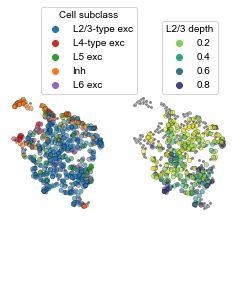

In [45]:
fig_umap, axs = plt.subplots(1,2, figsize=(4,5))
leg_kws = dict(loc='lower left', bbox_to_anchor=(0.28, 0.7), ncol=1)
ax = axs[0]
markers = dict(s=20, alpha=0.6, edgecolor='k')
df = data.sample(frac=1, random_state=42)
sns.scatterplot(data=df[df.cell_subclass.isna()], x='umap0', y='umap1', color='grey', s=10, ax=ax)
sns.scatterplot(data=df, x='umap0', y='umap1', hue='cell_subclass', palette=palette_subclass, ax=ax, **markers)
ax.legend(title="Cell subclass", **leg_kws)
ax.axis('off')
ax.axis('equal')

ax = axs[1]
l23_type = df['cell_subclass'].fillna('').str.contains('L2/3')
sns.scatterplot(data=df[~l23_type], x='umap0', y='umap1', color='grey', s=10, ax=ax)
sns.scatterplot(data=df[l23_type], x='umap0', y='umap1', hue='l23_depth', hue_norm=(0,1), palette='viridis_r', ax=ax, **markers)
plt.legend(title="L2/3 depth", **leg_kws)
ax.axis('off')
ax.axis('equal')
plt.show()

### How do axon/apical truncation differ between L2 and L3?

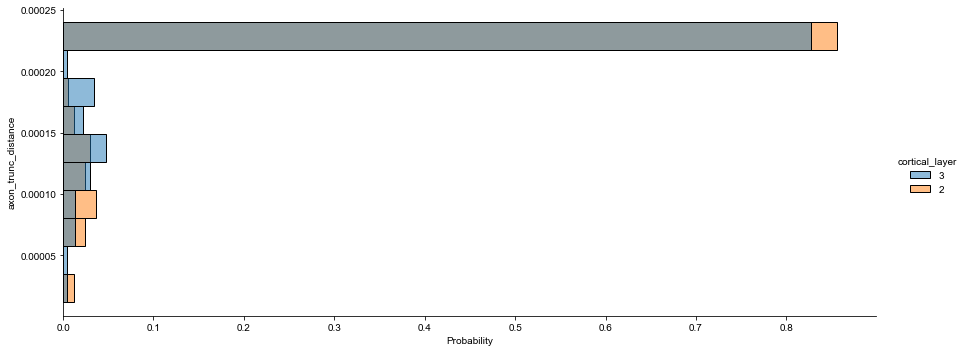

In [46]:
morph_df = human_df.copy()
morph_df.loc[lambda df:df['apical_truncation']=='intact','apical_trunc_distance'] = 1e-3
morph_df.loc[lambda df:df['axon_truncation']=='intact','axon_trunc_distance'] = 0.24e-3
sns.displot(data=morph_df[morph_df.cortical_layer.isin(['2','3'])], hue='cortical_layer', y='axon_trunc_distance',
            aspect=2.5, stat='probability', common_norm=False)

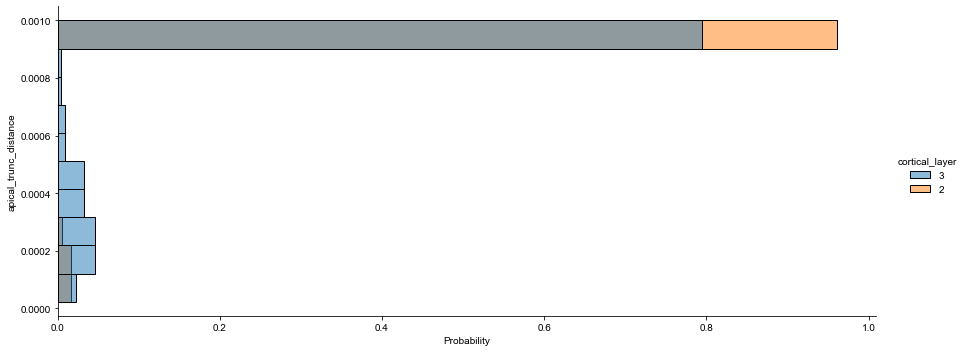

In [47]:
sns.displot(data=morph_df[morph_df.cortical_layer.isin(['2','3'])], hue='cortical_layer', y='apical_trunc_distance',
            aspect=2.5, stat='probability', common_norm=False)

In [48]:
# sns.displot(data=human_df[human_df.cell_class_nonsynaptic=='in'], x='l23_depth')
# l23_pairs_df = get_pairs(l23_class, l23_class, **human_pair_query_args)
# df = l23_pairs_df
# df.loc[df.cortical_layer=='2', 'l23_depth'] = l2/(l2+l3)*df.loc[df.cortical_layer=='2', 'fractional_layer_depth']
# df.loc[df.cortical_layer=='3', 'l23_depth'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[df.cortical_layer=='3', 'fractional_layer_depth']
# df.loc[df.cortical_layer_post=='2', 'l23_depth_post'] = l2/(l2+l3)*df.loc[
#     df.cortical_layer_post=='2', 'fractional_layer_depth_post']
# df.loc[df.cortical_layer_post=='3', 'l23_depth_post'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[
#     df.cortical_layer_post=='3', 'fractional_layer_depth_post']
# sns.displot(data=human_pairs_df[l23_pairs_df.cell_class_nonsynaptic=='in'], x='l23_depth')

# Example traces

In [49]:
from aisynphys.nwb_recordings import get_intrinsic_recording_dict, get_pulse_times, qc_recordings
import aisynphys.intrinsic_ephys as intrinsic

def get_sweep_set(expt, cell):
    dev_id = cell.electrode.device_id
    recording_dict = get_intrinsic_recording_dict(expt.data, dev_id)
    for rec_list in recording_dict.values():
        qc_recordings(expt, rec_list)

    recordings = recording_dict['LP']
    min_pulse_dur = np.inf
    sweep_list = []
    for rec in recordings:
        pulse_times = get_pulse_times(rec)
        if pulse_times is None:
            continue

        # pulses may have different durations as well, so we just use the smallest duration
        start, end = pulse_times
        min_pulse_dur = min(min_pulse_dur, end-start)

        sweep = intrinsic.MPSweep(rec, -start)
        if sweep is not None:
            sweep_list.append(sweep)

    if len(sweep_list) == 0:
        errors.append('No long square sweeps passed qc for cell %s' % cell_id)
        return {}, errors

    sweep_set = intrinsic.SweepSet(sweep_list)
    spx, spfx = intrinsic.extractors_for_sweeps(sweep_set, start=0, end=min_pulse_dur)
    lsa = intrinsic.LongSquareAnalysis(spx, spfx, subthresh_min_amp=-200,
                            #  require_subthreshold=False, require_suprathreshold=False
                             )
    try:
        analysis = lsa.analyze(sweep_set)
        return sweep_set, analysis
    except Exception as e:
        print(e)
        return sweep_set, None

In [50]:
examples = [
#     dict(name='Superficial', ext_id='1540346679.718', pair_ids=('8', '3'), l23_depth=0.025202),
    {'name': 'Superficial',
     'ext_id': '1540356446.981',
     'pair_ids': ('8', '2'),
     'l23_depth': 0.06575223719117307,},
#     dict(name='Deep', ext_id='1563916330.250', pair_ids=('4', '3'), l23_depth=0.752676),
    dict(name='Deep', ext_id='1533697449.182', pair_ids=('6', '4'), l23_depth=0.927916),
]
cmap = matplotlib.cm.get_cmap('viridis_r')
examples[0]['color'] = np.array(cmap(examples[0]['l23_depth'])[:3])*0.7
examples[1]['color'] = np.array(cmap(examples[1]['l23_depth'])[:3])

In [51]:
examples_pre = []
examples_post = []
for ex in examples:
    expt = db.experiment_from_ext_id(ex['ext_id'])
    cell = expt.cells[ex['pair_ids'][0]]
    cell_post = expt.cells[ex['pair_ids'][1]]
    examples_pre.append(cell.id)
    examples_post.append(cell_post.id)

    ex['sweep_set'], ex['analysis'] = get_sweep_set(expt, cell)

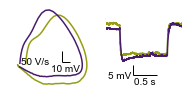

In [52]:
from aisynphys.ui.scalebars import add_scalebar
import matplotlib


fig_ephys_traces, axs = plt.subplots(1,2, figsize=(3, 1.5))

ax = axs[0]
for ex in examples:
    sweep_set, analysis = (ex['sweep_set'], ex['analysis'])
    spike_sweep = analysis['spiking_sweeps'].sort_values('stim_amp').iloc[0]

    sweep = sweep_set.sweeps[sweep_set.sweep_number.index(spike_sweep.sweep_number)]

    tt = sweep.t*1000-spike_sweep.latency*1000
    dt = tt[1]-tt[0]
    dvdt = np.gradient(sweep.v)/dt
    interval = (tt>0) & (tt<3)
    ax.plot(sweep.v[interval], dvdt[interval], c=ex['color'])
    
sb = add_scalebar(ax, matchx=False, sizex=10, labelx='10 mV', matchy=False, sizey=50, labely='50 V/s', 
                  loc='lower left',)
sb.set_bbox_to_anchor((19,20))

ax = axs[1]
for ex in examples:
    sweep_set, analysis = (ex['sweep_set'], ex['analysis'])
    sag_sweep = analysis['subthreshold_sweeps'].sort_values('stim_amp').iloc[0]['sweep_number']
    sweep = sweep_set.sweeps[sweep_set.sweep_number.index(sag_sweep)]

    ax.plot(sweep.t, sweep.v, c=ex['color'])
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-100, -60)
    
add_scalebar(ax, matchx=False, sizex=0.5, labelx='0.5 s', matchy=False, sizey=5, labely='5 mV', loc='lower left')

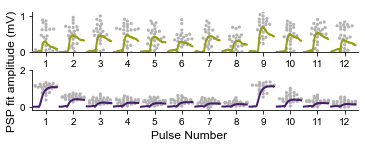

In [53]:
scatter_args = {'alpha': 1, 'size': 3.2}#, 'edgecolor': (0.7, 0.7, 0.7), 'linewidth': 0.7,}

fig, ax = plt.subplots(len(examples), 1, figsize=(5,2.1))

for pair_i, ex in enumerate(examples):
    expt_id, pair_ids = (ex['ext_id'], ex['pair_ids'])
    color = ex['color']
    pair = db.experiment_from_ext_id(expt_id).pairs[pair_ids]
    
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        nb.plot_stim_sorted_pulse_amp(pair, ax[pair_i], avg_trace=True, scatter_args=scatter_args, line_args=dict(color=color))

[a.set_xlabel('') for a in ax]
[a.set_ylabel('') for a in ax]
fig.text(-0.005, 0.45, 'PSP fit amplitude (mV) ', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, -0.01, 'Pulse Number', ha='center', rotation='horizontal', fontsize=12)

plt.tight_layout(w_pad=0.1, h_pad=0.2, rect=(0,0,1,0.9))
# ax[0].set_ylim(-0.1, 1)
ax[1].set_ylim(-0.2, 2)
fig_psp_train_example = fig

In [54]:
## Examples search - out of order
# ex = ex_df.iloc[5]
# examples[0] = dict(name='Superficial', ext_id=ex.exp_ext_id, pair_ids=(ex.pre_ext_id, ex.post_ext_id), l23_depth=ex.l23_depth)
# examples[0]['color'] = np.array(cmap(examples[0]['l23_depth'])[:3])*0.7
# scatter_args = {'alpha': 1, 'size': 3.2}#, 'edgecolor': (0.7, 0.7, 0.7), 'linewidth': 0.7,}

# # fig, ax = plt.subplots(len(examples), 1, figsize=(5,2))
# fig, ax = plt.subplots(len(examples), 1, figsize=(15,10))

# for pair_i, ex in enumerate(examples):
#     expt_id, pair_ids = (ex['ext_id'], ex['pair_ids'])
#     color = ex['color']
#     pair = db.experiment_from_ext_id(expt_id).pairs[pair_ids]
    
#     import warnings
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", category=UserWarning)
#         nb.plot_stim_sorted_pulse_amp(pair, ax[pair_i], avg_trace=True, scatter_args=scatter_args, 
#                                       line_args=dict(color=color, linewidth=3),
#                                  time_slice=(-1e-3, 9e-3), show_traces=True)

# [a.set_xlabel('') for a in ax]
# [a.set_ylabel('') for a in ax]
# fig.text(-0.005, 0.55, 'PSP fit amplitude (mV)', va='center', rotation='vertical', fontsize=12)
# fig.text(0.5, -0.01, 'Pulse Number', ha='center', rotation='horizontal', fontsize=12)

# plt.tight_layout(w_pad=0.1, h_pad=0.2)
# # ax[0].set_ylim(-0.1, 1)
# # ax[1].set_ylim(-0.2, 2)

# Depth dependence

In [55]:
import patsy
import sklearn.linear_model as sklm
import sklearn.model_selection as skms
# TODO: make this fully interchangeable, not using res from statsmodels result for plot
def ols_cv(data, formula_rhs, feature, n_splits=5, n_repeats=50):
    formula = f"{feature} ~ {formula_rhs}"
    y, X = patsy.dmatrices(formula, data, return_type='matrix')
    scorers = ["r2", "explained_variance", "neg_root_mean_squared_error"]
    # TODO: adapt stratified KFold to use groups
#     cv = skms.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
    cv = skms.RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    estimator = sklm.LinearRegression()
    scores = skms.cross_validate(estimator, X, y, scoring=scorers, cv=cv, return_train_score=True)
    fit_dict = {key: np.mean(val) for key, val in scores.items()}
    std_dict = {key+"_std": np.std(val) for key, val in scores.items()}
#     get bounds of 95% conf int
    min_dict = {key+"_min": np.percentile(val, 2.75) for key, val in scores.items()}
    max_dict = {key+"_max": np.percentile(val, 97.5) for key, val in scores.items()}
    fit_dict.update(**std_dict, **min_dict, **max_dict)
    return fit_dict

import statsmodels.formula.api as smf

def fit_conf_int(data, x, y, **cvargs):
    cov_type = "HC3"
    res = smf.ols(formula=f"{y}~{x}", data=data).fit(cov_type=cov_type)
    coeff = res.params[x]
#     err = res.bse[x]
    conf_int = res.conf_int().loc[x]
    result = {'coeff':coeff,
            'coeff_min':conf_int[0],
            'coeff_max':conf_int[1],
            'prop':y}
    cv_result = ols_cv(data, x, y, **cvargs)
    result.update(cv_result)
    return result


In [56]:
cell_info = (session.query(db.Cell)
                .outerjoin(db.CorticalCellLocation)
                .outerjoin(db.Intrinsic)
                .add_entity(db.CorticalCellLocation)
                .add_entity(db.Intrinsic)
                .dataframe(rename_columns=False))
cell_info = cell_info.loc[:, lambda df: ~df.columns.duplicated()]
cell_info = cell_info.set_index('id')

human_pair_query_args = pair_query_args

def get_pairs(pre_class, post_class, **kwargs):
    pair_query = db.pair_query(
            pre_class=pre_class,
            post_class=post_class,
            **kwargs
    )
    pair_query = (pair_query.add_entity(db.Dynamics).add_entity(db.Synapse)
                          .add_column(db.Experiment.storage_path)
                          .add_column(db.Experiment.ext_id.label('exp_ext_id'))
                             .add_column(pair_query.pre_cell.ext_id.label('pre_ext_id'))
                             .add_column(pair_query.post_cell.ext_id.label('post_ext_id'))
                 )
    
    pairs_df = (pair_query.dataframe(rename_columns=False)
                .join(cell_info, on='pre_cell_id', rsuffix='_r')
                .join(cell_info, on='post_cell_id', rsuffix='_post')
                .loc[:, lambda df: ~df.columns.duplicated()]
               )
    n_depth = pairs_df.fractional_layer_depth.notna().sum()
    n_apud = pairs_df.ap_upstroke_downstroke_ratio.notna().sum()
    print(f"{len(pairs_df)} pairs, {n_depth} with depth info, {n_apud} with AP props")
    return pairs_df

In [57]:
e_23_class =  CellClass(cell_class='ex', cortical_layer='2/3',)
l23_class =  CellClass( cortical_layer='2/3',)
mouse_pairs_df = get_pairs(e_23_class, l23_class, **mouse_pair_query_args)
mouse_pairs_df.sag.loc[lambda x: x>1] = np.nan

100 pairs, 88 with depth info, 57 with AP props


In [58]:
mouse_pairs_df.dropna(subset=['fractional_layer_depth']).cell_class_post.value_counts()

in       63
ex       16
mixed     5
Name: cell_class_post, dtype: int64

In [59]:
e_23_class =  CellClass(db.Intrinsic.input_resistance<225e6, cell_class='ex', cortical_layer=('2','3'))
l23_class =  CellClass( cortical_layer=('2','3'),)
human_pairs_df = get_pairs(e_23_class, l23_class, **human_pair_query_args)

124 pairs, 110 with depth info, 108 with AP props


In [60]:
human_pairs_df.dropna(subset=['fractional_layer_depth']).cell_class_post.value_counts()

ex       80
in       20
mixed     2
Name: cell_class_post, dtype: int64

In [61]:
# avg layer thicknesses
l2 = 407.2001623338 - 247.2137476577
l3 = 1363.9197375716 - 407.2001623338

df = human_pairs_df
df.loc[df.cortical_layer=='2', 'l23_depth'] = l2/(l2+l3)*df.loc[df.cortical_layer=='2', 'fractional_layer_depth']
df.loc[df.cortical_layer=='3', 'l23_depth'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[df.cortical_layer=='3', 'fractional_layer_depth']
df.loc[df.cortical_layer_post=='2', 'l23_depth_post'] = l2/(l2+l3)*df.loc[
    df.cortical_layer_post=='2', 'fractional_layer_depth_post']
df.loc[df.cortical_layer_post=='3', 'l23_depth_post'] = l2/(l2+l3) + l3/(l2+l3)*df.loc[
    df.cortical_layer_post=='3', 'fractional_layer_depth_post']

mouse_pairs_df['l23_depth'] = mouse_pairs_df['fractional_layer_depth']
mouse_pairs_df['l23_depth_post'] = mouse_pairs_df['fractional_layer_depth_post']

# categorical for comparison
cutoff = 0.575
human_pairs_df['is_deep'] = (human_pairs_df['l23_depth'] > cutoff).astype(int).where(human_pairs_df['l23_depth'].notna())
mouse_pairs_df['is_deep'] = (mouse_pairs_df['l23_depth'] > cutoff).astype(int).where(mouse_pairs_df['l23_depth'].notna())

datasets = {'human': human_pairs_df,
           'mouse': mouse_pairs_df}

In [62]:
# select examples (defined above)
pd.options.display.max_columns=200
ex_df = human_pairs_df.query("l23_depth<0.1 & stp_initial_50hz>-0.05 & sag<0.1 & ap_upstroke_downstroke_ratio<3")
ex_df.head(6)

id  experiment_id  pre_cell_id  post_cell_id  has_synapse  \
1   71717           2173        12713         12707         True   
2   71719           2173        12713         12709         True   
20  73159           2222        12983         12986         True   
21  73172           2222        12986         12983         True   
26  71727           2175        12716         12721         True   
39  55081           1609         9561          9562         True   

    has_polysynapse  has_electrical crosstalk_artifact  n_ex_test_spikes  \
1             False           False               None               420   
2             False           False               None               420   
20            False           False               None               574   
21            False           False               None               598   
26            False           False               None               630   
39            False           False               None              1006   

    n_in_test_spikes  distance  lateral_distance  vertical_distance  \
1                 60  0.000111          0.000072           0.000029   
2                 60  0.000231          0.000074           0.000174   
20                60  0.000045          0.000027           0.000019   
21                60  0.000045          0.000027           0.000019   
26                60  0.000158          0.000141           0.000015   
39               300  0.000071          0.000060           0.000017   

    reciprocal_id  meta  pair_id  qc_pass  n_source_events  \
1           71680  None    71717     True              299   
2           71694  None    71719     True              299   
20          73172  None    73159     True              420   
21          73159  None    73172     True              430   
26          71753  None    71727     True              484   
39          55088  None    55081     True              478   

    paired_pulse_ratio_50hz  stp_initial_50hz  stp_initial_50hz_n  \
1                  0.765734          0.095368                25.0   
2                  0.920890         -0.000843                25.0   
20                 0.959330          0.000261                17.0   
21                 0.153726          0.160567                25.0   
26                 0.885234          0.162848                29.0   
39                 0.878354         -0.043930                25.0   

    stp_initial_50hz_std  stp_induction_50hz  stp_induction_50hz_n  \
1               0.552385           -0.075192                  25.0   
2               0.585213           -0.375644                  25.0   
20              0.523996           -0.339751                  17.0   
21              0.701829           -0.152025                  25.0   
26              0.593041           -0.211837                  29.0   
39              0.313693           -0.011257                  25.0   

    stp_induction_50hz_std  stp_recovery_250ms  stp_recovery_250ms_n  \
1                 0.473915           -0.044545                   5.0   
2                 0.377947           -0.042647                   5.0   
20                0.432855           -0.221380                  13.0   
21                0.559120            0.010149                  15.0   
26                0.444618            0.132003                  16.0   
39                0.385071            0.191105                  19.0   

    stp_recovery_250ms_std  stp_recovery_single_250ms  \
1                 0.156998                   0.263204   
2                 0.161771                   0.507326   
20                0.209204                  -0.031565   
21                0.264418                   0.139054   
26                0.146627                   0.105153   
39                0.233106                   0.544935   

    stp_recovery_single_250ms_n  stp_recovery_single_250ms_std  \
1                           5.0                       0.585996   
2                           5.0                     

In [63]:
prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction',
    "stp_recovery_250ms": 'STP recovery',
}
x = 'l23_depth'
metric = 'coeff'
colors = {'human':'tab:blue',
         'mouse':'tab:brown'}
def plot_reg_comparison(datasets, prop_names, x, metric, colors, conf_int='interval', **cvargs):
    dx = 0.05
    props = prop_names.keys()
    xx = np.arange(len(props))

    plt.figure(figsize=(3,3))
    for n, (name, data) in enumerate(datasets.items()):
        res = pd.DataFrame.from_records( [fit_conf_int(data, x, y) for y in props])
        plt.plot(res[metric], xx-n*dx, 'o', label=name, c=colors[name])
        for i in xx:
            if conf_int=='interval':
                plt.plot(res.loc[i, [f'{metric}_min', f'{metric}_max']], 2*[i-n*dx], c=colors[name])
            elif conf_int=='std':
                plt.plot(res.loc[i, f'{metric}'] + np.array([-1,1])*res.loc[i, f'{metric}_std'],
                         2*[i-n*dx], c=colors[name])
                

    plt.legend()
    plt.yticks(ticks=xx, labels=[prop_names[p] for p in props])
    plt.xlabel(metric)
    

### Species comparison regplots

In [64]:
human_pairs_df = human_pairs_df.loc[:, lambda df: ~df.columns.duplicated()]
mouse_pairs_df = mouse_pairs_df.loc[:, lambda df: ~df.columns.duplicated()]
species_df = pd.concat([human_pairs_df.assign(species='human'), mouse_pairs_df.assign(species='mouse')], sort=True)
species_df = species_df[species_df.cell_class_post!='mixed']

In [65]:
def plot_paired_scatter(species_df, var, prop_names, examples_pre, examples_post, style=None, hue='species',
                        height=2, aspect=1.5, leg=None, leg_ax=1, leg_kws={}, colors=colors, orient='vert'):
    props = list(prop_names.keys())
    var_name = 'property'
    if orient=='vert':
        prop_var = 'y'
        xy = {'x':var, 'y':'value',}
        extra = {'col_wrap':1, 'sharey':False,}
    else:
        prop_var = 'x'
        xy = {'y':var, 'x':'value'}
        extra = {'sharex': False,}
    plot_df = species_df.melt(value_vars=props, id_vars=[var, hue], var_name=var_name)
    g = sns.lmplot(data=plot_df, hue=hue, col=var_name, col_order=props, 
                   height=height, aspect=aspect, legend=False, palette=colors, 
                  scatter_kws=dict(s=0), **xy, **extra)
    axs = g.axes.ravel()
    for i, prop in enumerate(props):
        xy[prop_var] = prop
        s = sns.scatterplot(data=species_df, s=40, hue=hue, style=style,
                        palette=colors, legend=False, ax=axs[i], **xy)
        
        if examples_pre is not None:
            cells = species_df[species_df.cell_id.isin(examples_pre) & species_df.cell_id_post.isin(examples_post)]
            sns.scatterplot(data=cells, s=80, zorder=10, style=style,
                            hue='l23_depth', hue_norm=(0,1), palette='viridis_r', legend=False, ax=axs[i], **xy)
        axs[i].set_title(None)
        if orient=='vert':
            axs[i].set_ylabel(prop_names[prop], fontsize=12)
        else:
            axs[i].set_xlabel(prop_names[prop], fontsize=12)
    if leg:
        ax = g.fig.add_subplot(3,1,3)
        if leg=='hue':
            s = sns.scatterplot(data=species_df, s=40, hue=hue, palette=colors, ax=ax, zorder=-100, **xy)
        if leg=='style':
            s = sns.scatterplot(data=species_df, s=40, style=style, ax=ax, zorder=-100, **xy)
        axs[leg_ax].legend(*s.get_legend_handles_labels(), **leg_kws)
        ax.set_visible(False)
    return g

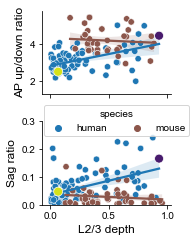

In [66]:
x = 'l23_depth'
prop_names = {'ap_upstroke_downstroke_ratio':'AP up/down ratio', 
              'sag':'Sag ratio',
             }
leg_kws = dict(loc='upper center', bbox_to_anchor=(0.58, 1.25), title='species', ncol=2)
g = plot_paired_scatter(species_df, x, prop_names, examples_pre, examples_post, aspect=1.6, height=1.7,
                        leg='hue', leg_kws=leg_kws)
g.axes[1].set_ylim(0,0.3)
g.set_xlabels('L2/3 depth', fontsize=12)
fig_e_r = g.fig

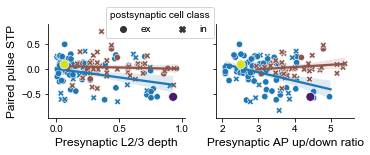

In [67]:
var = 'stp_initial_50hz'
prop_names = {
    "l23_depth": 'Presynaptic L2/3 depth',
    "ap_upstroke_downstroke_ratio": 'Presynaptic AP up/down ratio',
}
leg_kws = dict(loc='lower right', bbox_to_anchor=(0.02, 0.8), title='postsynaptic cell class', ncol=2)
g = plot_paired_scatter(species_df, var, prop_names, examples_pre, examples_post, aspect=1.3, style='cell_class_post', 
                        leg='style', leg_kws=leg_kws, orient='horiz')
g.set_ylabels('Paired pulse STP', fontsize=12)
fig_f_horiz = g.fig

In [68]:
import statsmodels.api as sm
x = 'l23_depth'
y = "stp_initial_50hz"
res = smf.ols(formula=f"{y}~{x}", data=human_pairs_df).fit(cov_type="HC3")
predictions = res.get_prediction(sm.add_constant([0,1]), transform=False)
predictions.summary_frame(alpha=0.05)

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  0.004058  0.034764      -0.064078       0.072195     -0.514622   
1 -0.306672  0.095009      -0.492885      -0.120458     -0.853538   

   obs_ci_upper  
0      0.522738  
1      0.240194

In [69]:
res = smf.ols(formula=f"{y}~{x}", data=mouse_pairs_df).fit(cov_type="HC3")
predictions = res.get_prediction(sm.add_constant([0,1]), transform=False)
predictions.summary_frame(alpha=0.05)

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  0.062516  0.062187      -0.059368       0.184399     -0.339838   
1  0.004225  0.055378      -0.104315       0.112764     -0.394289   

   obs_ci_upper  
0      0.464869  
1      0.402739

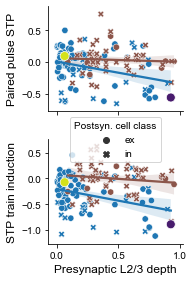

In [70]:
x = 'l23_depth'
prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction',
}
leg_kws = dict(loc='upper center', bbox_to_anchor=(0.5, 1.25), title='Postsyn. cell class')
g = plot_paired_scatter(species_df, x, prop_names, examples_pre, examples_post, aspect=1.3, style='cell_class_post', 
                        leg='style', leg_kws=leg_kws)
g.set_xlabels('Presynaptic L2/3 depth', fontsize=12)
fig_f_l = g.fig

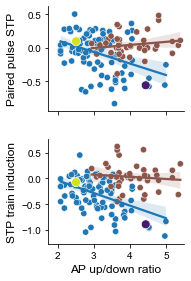

In [71]:
x = 'ap_upstroke_downstroke_ratio'
prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction',
}
g = plot_paired_scatter(species_df, x, prop_names, examples_pre, examples_post, aspect=1.3)
g.axes[0].set_xlim(None,5.5)
g.set_xlabels('AP up/down ratio', fontsize=12)
fig_f_r = g.fig

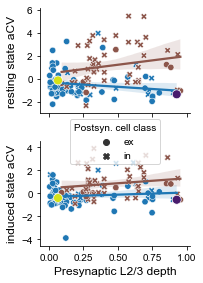

In [72]:
x = 'l23_depth'
prop_names = {
    'variability_resting_state': 'resting state aCV',
    'variability_stp_induced_state_50hz': 'induced state aCV',
}
leg_kws = dict(loc='upper center', bbox_to_anchor=(0.5, 1.25), title='Postsyn. cell class')
g = plot_paired_scatter(species_df, x, prop_names, examples_pre, examples_post, aspect=1.5, style='cell_class_post', 
                        leg='style', leg_kws=leg_kws)
g.set_xlabels('Presynaptic L2/3 depth', fontsize=12)

### Supplemental STP-depth plots

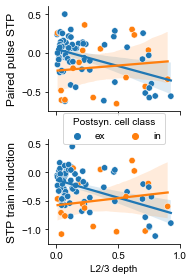

In [73]:
x = 'l23_depth'
prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction',
}
df = human_pairs_df[human_pairs_df.cell_class_post!='mixed']
leg_kws = dict(loc='lower center', bbox_to_anchor=(0.5, 0.9), title='Postsyn. cell class', ncol=2)
g = plot_paired_scatter(df, x, prop_names, None, examples_post, aspect=1.3,
                        hue='cell_class_post', leg='hue', leg_kws=leg_kws, leg_ax=1, colors='tab10')
g.set_xlabels('L2/3 depth')
supp_human_post_types = g.fig

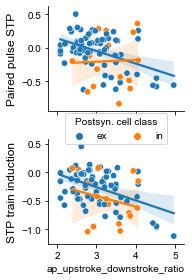

In [74]:
x = 'ap_upstroke_downstroke_ratio'
leg_kws = dict(loc='lower center', bbox_to_anchor=(0.5, 0.9), title='Postsyn. cell class', ncol=2)
g = plot_paired_scatter(df, x, prop_names, None, examples_post, aspect=1.3,
                        hue='cell_class_post', leg='hue', leg_kws=leg_kws, leg_ax=1, colors='tab10')
# g.set_xlabels('L2/3 depth')

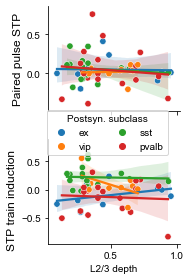

In [75]:
x = 'l23_depth'
prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction     ',
}
df = mouse_pairs_df[mouse_pairs_df.cell_class_post!='mixed'].copy()
df.loc[lambda df: ((df['cre_type_post']=='nr5a1') | (df['cre_type_post']=='unknown')) &
                   (df['cell_class_post']=='ex'), 'cre_type_post'] = 'ex'
df = df[df.cre_type_post!='unknown']
leg_kws = dict(loc='lower center', bbox_to_anchor=(0.45, 0.8), title='Postsyn. subclass', ncol=2)
g = plot_paired_scatter(df, x, prop_names, None, examples_post, aspect=1.3,
                        hue='cre_type_post', leg='hue', leg_kws=leg_kws, leg_ax=1, colors='tab10')
g.set_xlabels('L2/3 depth')
g.axes[1].set_ylim(None,0.9)
supp_mouse_post_types = g.fig

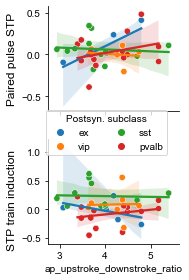

In [76]:
x = 'ap_upstroke_downstroke_ratio'
leg_kws = dict(loc='lower center', bbox_to_anchor=(0.45, 0.8), title='Postsyn. subclass', ncol=2)
g = plot_paired_scatter(df, x, prop_names, None, examples_post, aspect=1.3,
                        hue='cre_type_post', leg='hue', leg_kws=leg_kws, leg_ax=1, colors='tab10')
# g.set_xlabels('L2/3 depth')
# g.axes[1].set_ylim(None,0.9)

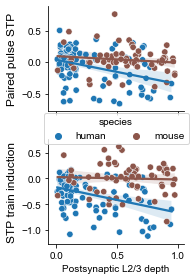

In [77]:
x = 'l23_depth_post'
prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction',
}
leg_kws = dict(loc='lower center', bbox_to_anchor=(0.5, 0.9), title='species', ncol=2)
g = plot_paired_scatter(species_df, x, prop_names, None, examples_post, aspect=1.3, leg='hue', leg_kws=leg_kws)
g.set_xlabels('Postsynaptic L2/3 depth')
supp_depth_post = g.fig

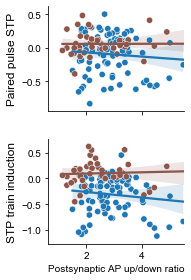

In [78]:
x = 'ap_upstroke_downstroke_ratio_post'
prop_names = {
    "stp_initial_50hz": 'Paired pulse STP',
    "stp_induction_50hz": 'STP train induction',
}
g = plot_paired_scatter(species_df, x, prop_names, None, examples_post, aspect=1.3)
g.axes[0].set_xlim(None,5.5)
g.set_xlabels('Postsynaptic AP up/down ratio')
supp_updown_post = g.fig

In [79]:
def reg_results(species_df, xprops, yprops):
    records = []
    cov_type = "HC3"
    for species, df in species_df.groupby('species'):
        for x in xprops:
            for y in yprops:
                res = smf.ols(formula=f"{y}~{x}", data=df).fit(cov_type=cov_type)
                conf_int = res.conf_int().loc[x]
                results = {'p_coeff': res.pvalues[x],
                           'p_ftest': res.f_pvalue,
                           'coeff': res.params[x],
                            'coeff_min':conf_int[0],
                            'coeff_max':conf_int[1],
#                            'intercept': res.params['Intercept'],
                           'rsquared': res.rsquared,
                           'x':x,
                           'y':y,
                           'species':species,
                          }
                records.append(results)
    return pd.DataFrame.from_records(records)

In [80]:
xprops = [
    'l23_depth',
]
yprops = [
    'ap_upstroke_downstroke_ratio',
    'sag',
]
pd.options.display.precision = 2
reg_results(species_df, xprops, yprops)

p_coeff   p_ftest  coeff  coeff_min  coeff_max  rsquared          x  \
0  6.76e-05  1.37e-04   1.26       0.64       1.87  2.55e-01  l23_depth   
1  2.54e-05  5.35e-05   0.10       0.05       0.15  2.43e-01  l23_depth   
2  6.14e-01  6.17e-01  -0.28      -1.38       0.82  6.90e-03  l23_depth   
3  2.60e-01  2.65e-01  -0.02      -0.05       0.01  1.76e-02  l23_depth   

                              y species  
0  ap_upstroke_downstroke_ratio   human  
1                           sag   human  
2  ap_upstroke_downstroke_ratio   mouse  
3                           sag   mouse

In [81]:
xprops = [
    'l23_depth',
#     'l23_depth_post',
    'ap_upstroke_downstroke_ratio',
    'ap_upstroke_downstroke_ratio_post',
#     'ap_upstroke',
]
yprops = [
    'stp_initial_50hz',
#     'stp_induction_50hz',
]
reg_results(species_df, xprops, yprops)

p_coeff   p_ftest     coeff  coeff_min  coeff_max  rsquared  \
0  1.75e-03  2.37e-03 -3.49e-01      -0.57      -0.13  1.10e-01   
1  2.99e-05  6.79e-05 -1.72e-01      -0.25      -0.09  1.53e-01   
2  4.57e-01  4.59e-01 -3.12e-02      -0.11       0.05  7.51e-03   
3  5.86e-01  5.88e-01 -5.83e-02      -0.27       0.15  4.33e-03   
4  2.45e-01  2.52e-01  4.59e-02      -0.03       0.12  2.94e-02   
5  9.80e-01  9.80e-01  7.37e-04      -0.06       0.06  2.79e-05   

                                   x                 y species  
0                          l23_depth  stp_initial_50hz   human  
1       ap_upstroke_downstroke_ratio  stp_initial_50hz   human  
2  ap_upstroke_downstroke_ratio_post  stp_initial_50hz   human  
3                          l23_depth  stp_initial_50hz   mouse  
4       ap_upstroke_downstroke_ratio  stp_initial_50hz   mouse  
5  ap_upstroke_downstroke_ratio_post  stp_initial_50hz   mouse

Text(0.5, 0, '$\\Delta$ STP by depth (L2/3)')

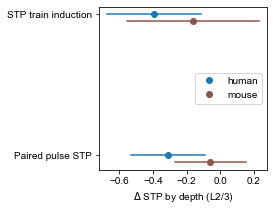

In [82]:
metric='coeff'
x = 'l23_depth'
plot_reg_comparison(datasets, prop_names, x, metric, colors)
plt.xlabel('$\Delta$ STP by depth (L2/3)')

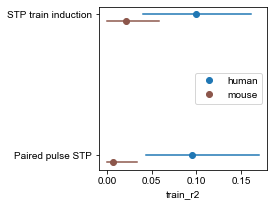

In [83]:
metric='train_r2'
x = 'l23_depth'
plot_reg_comparison(datasets, prop_names, x, metric, colors, conf_int='interval', n_splits=3, n_repeats=100)

### Compare with categorical depth

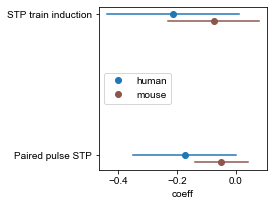

In [84]:
metric='coeff'
x = 'is_deep'
plot_reg_comparison(datasets, prop_names, x, metric, colors)

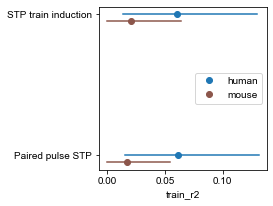

In [85]:
metric='train_r2'
x = 'is_deep'
plot_reg_comparison(datasets, prop_names, x, metric, colors, conf_int='interval', n_splits=2, n_repeats=100)

### Human polysynaptic events

In [3]:
cell_class_criteria = {
    'l2pyr': {'dendrite_type': 'spiny', 'cortical_layer': '2'},
    'l3pyr': {'dendrite_type': 'spiny', 'cortical_layer': '3'},
    'l4pyr': {'dendrite_type': 'spiny', 'cortical_layer': '4'},
    'l5pyr': {'dendrite_type': 'spiny', 'cortical_layer': '5'},
    'l5pyr': {'dendrite_type': 'spiny', 'cortical_layer': ('6', '6a', '6b')},
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [12]:
def syn_type(row):
    if row['has_synapse']:
        syn_type = 'monosynaptic'
    elif row['has_polysynapse']:
        syn_type = 'polysynaptic'
    else:
        syn_type = None
    return syn_type

human_pairs = None
for pre_name, pre_class in cell_classes.items():
    for post_name, post_class in cell_classes.items():
        pair_query = db.pair_query(
            project_name='human coarse matrix',
            pre_class=pre_class,
            post_class=post_class,
        )
        pair_query = pair_query.outerjoin(db.PolySynapse, db.PolySynapse.pair_id==db.Pair.id)
        pair_query = pair_query.add_columns(
            db.Synapse.psp_amplitude,
            db.Synapse.latency,
            db.PolySynapse.psp_amplitude,
            db.PolySynapse.latency,
        )
        df = pair_query.dataframe(rename_columns=False)
        df['pre_class'] = pre_name
        df['post_class'] = post_name
        df['pair_class'] = pre_name + "→" + post_name
        if pre_class.as_tuple[0] == post_class.as_tuple[0] or ('6' in pre_class.as_tuple[0] and '6' in post_class.as_tuple[0]):
            df['layer'] = 'intra'
        else:
            df['layer'] = 'inter'
        if human_pairs is None:
            human_pairs = df
        else:
            human_pairs = human_pairs.append(df)
            
human_pairs['syn_type'] = human_pairs.apply(lambda row: syn_type(row), axis=1)  
human_pairs = human_pairs[~human_pairs['syn_type'].isna()]
human_syn = human_pairs.groupby(level=0, axis=1).agg(np.nansum)
human_syn['psp_amplitude'] = human_syn.apply(lambda x: x['psp_amplitude'] if x['psp_amplitude'] != 0 else np.nan, axis=1)
print(len(human_syn))
human_syn.head()


178


crosstalk_artifact  distance  experiment_id  has_electrical  \
0                  0.0  0.000118         2396.0             0.0   
1                  0.0  0.000052         2396.0             0.0   
6                  0.0  0.000122         1892.0             0.0   
19                 0.0  0.000137         2172.0             0.0   
20                 0.0  0.000137         2172.0             0.0   

    has_polysynapse  has_synapse       id   latency  lateral_distance  layer  \
0               0.0          1.0  77093.0  0.000000          0.000029  intra   
1               1.0          0.0  77098.0  0.004189          0.000039  intra   
6               1.0          0.0  62786.0  0.004399          0.000102  intra   
19              0.0          1.0  70726.0  0.000000          0.000089  intra   
20              1.0          0.0  70743.0  0.003320          0.000089  intra   

    ...  n_in_test_spikes   pair_class  post_cell_id post_class  pre_cell_id  \
0   ...               0.0  l2pyr→l2pyr       13820.0      l2pyr      13819.0   
1   ...               0.0  l2pyr→l2pyr       13825.0      l2pyr      13819.0   
6   ...              60.0  l2pyr→l2pyr       11065.0      l2pyr      11058.0   
19  ...              60.0  l2pyr→l2pyr       12598.0      l2pyr      12594.0   
20  ...              60.0  l2pyr→l2pyr       12594.0      l2pyr      12598.0   

   pre_class  psp_amplitude reciprocal_id      syn_type  vertical_distance  
0      l2pyr            NaN       77099.0  monosynaptic           0.000087  
1      l2pyr            NaN       77129.0  polysynaptic           0.000010  
6      l2pyr            NaN       62838.0  polysynaptic           0.000035  
19     l2pyr            NaN       70743.0  monosynaptic           0.000061  
20     l2pyr            NaN       70726.0  polysynaptic           0.000061  

[5 rows x 22 columns]

In [13]:
human_copy = human_syn.copy()
human_copy = human_copy[(human_copy['latency']>0) & (~human_copy['psp_amplitude'].isna())]
human_copy['psp_amplitude']*=1e3
human_copy['latency']*=1e3

l2 = human_copy[human_copy['pre_class']=='l2pyr']
l3 = human_copy[human_copy['pre_class']=='l3pyr']
l23 = human_copy[human_copy['pre_class'].isin(['l2pyr','l3pyr'])]

l3[l3['has_polysynapse']==True]

crosstalk_artifact  distance  experiment_id  has_electrical  \
152                 0.0  0.000226         2024.0             0.0   
63                  0.0  0.000127         2181.0             0.0   
105                 0.0  0.000161         2292.0             0.0   
120                 0.0  0.000120          964.0             0.0   
181                 0.0  0.000156         1532.0             0.0   
292                 0.0  0.000208          956.0             0.0   
320                 0.0  0.000203         2023.0             0.0   

     has_polysynapse  has_synapse       id   latency  lateral_distance  layer  \
152              1.0          0.0  66585.0  4.182047          0.000138  inter   
63               1.0          0.0  70917.0  3.751852          0.000069  intra   
105              1.0          0.0  74053.0  5.679662          0.000132  intra   
120              1.0          0.0  36056.0  4.810478          0.000114  intra   
181              1.0          0.0  52036.0  4.475627          0.000114  intra   
292              1.0          0.0  35911.0  3.786258          0.000156  intra   
320              1.0          0.0  66519.0  7.704220          0.000119  intra   

     ...  n_in_test_spikes   pair_class  post_cell_id post_class  pre_cell_id  \
152  ...              60.0  l3pyr→l2pyr       11789.0      l2pyr      11786.0   
63   ...             603.0  l3pyr→l3pyr       12636.0      l3pyr      12635.0   
105  ...              60.0  l3pyr→l3pyr       13235.0      l3pyr      13241.0   
120  ...             187.0  l3pyr→l3pyr        5989.0      l3pyr       5985.0   
181  ...              60.0  l3pyr→l3pyr        9046.0      l3pyr       9049.0   
292  ...              60.0  l3pyr→l3pyr        5949.0      l3pyr       5952.0   
320  ...              60.0  l3pyr→l3pyr       11779.0      l3pyr      11776.0   

    pre_class  psp_amplitude reciprocal_id      syn_type  vertical_distance  
152     l3pyr       0.482034       66608.0  polysynaptic           0.000128  
63      l3pyr      -0.196832       70918.0  polysynaptic           0.000084  
105     l3pyr       0.394166       74016.0  polysynaptic           0.000061  
120     l3pyr      -0.051655       36077.0  polysynaptic           0.000009  
181     l3pyr       0.705738       52023.0  polysynaptic           0.000087  
292     l3pyr       0.213391       35895.0  polysynaptic           0.000099  
320     l3pyr       0.240424       66535.0  polysynaptic           0.000135  

[7 rows x 22 columns]

In [8]:
def plot_traces(pair, mode=None, holding=None, ax=None, color='b'):
    from aisynphys.avg_response_fit import response_query, sort_responses
    from aisynphys.data import PulseResponseList
    s = db.session()
    records = response_query(session=s, pair=pair)
    prs = [rec[0] for rec in records]
    sort_prs = sort_responses(prs)
    qc_pass_resp = sort_prs[(mode, holding)]['qc_pass']
    pr_list = PulseResponseList(qc_pass_resp)
    post_trace = pr_list.post_tseries(align='spike', bsub=True, bsub_win=0.3e-3)
    spike = pr_list.pre_tseries(align='spike', bsub=False, alignment_failure_mode='average')
#     for trace in pr_list[10:20]:
#         ax.plot(trace.time_values, trace.data, color=(0, 0, 0, 0.4), lw=1)
    if len(qc_pass_resp)>0:
        spike_avg = spike.mean()*1e3
        ax[0].plot(spike_avg.time_values*1e3, spike_avg.data, color='k')
        avg = post_trace.mean()*1e3
        ax[1].plot(avg.time_values*1e3, avg.data, color=color, linewidth=2)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].get_xaxis().set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
    latency = pair.synapse.latency if pair.synapse is not None else pair.poly_synapse[0].latency
    ax[1].axvline(latency*1e3, color=color, ls='--', lw=0.8)

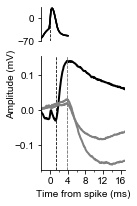

In [9]:
from matplotlib import gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from aisynphys.ui.scalebars import add_scalebar
expt = db.experiment_from_ext_id('1555458438.505')
set1 = {
    ('7', '8'): {'color':'k', 'norm': 1},
    ('7', '1'): {'color':'grey', 'norm': -1},
    ('7', '2'): {'color':'grey', 'norm': -1}
}

set2 = {
    ('8', '7'): {'color':'k', 'norm': 1},
    ('8', '1'): {'color':'grey', 'norm': -1},
    ('8', '2'): {'color':'grey', 'norm': -1}
}

trace_fig = plt.figure(figsize=(1.5,3))
grid = gridspec.GridSpec(2, 1, height_ratios=[0.3,1])
ax_spike = trace_fig.add_subplot(grid[0])
ax_post = trace_fig.add_subplot(grid[1], sharex=ax_spike)
ax = [ax_spike, ax_post]

# for pair, opts in set1.items():
#     plot_traces(expt.pairs[pair], mode='ic', holding=-70, ax=ax[0], color=opts['color'], norm=opts['norm'])
    
for pair, opts in set2.items():
    plot_traces(expt.pairs[pair], mode='ic', holding=-70, ax=ax, color=opts['color'])
    
ax_post.set_xlim(-2, 17)
ax_post.xaxis.set_major_locator(MultipleLocator(4))
ax_post.xaxis.set_minor_locator(MultipleLocator(2))
ax_spike.axvline(0, color='k', ls='--', lw=0.8)
ax_spike.set_yticks([0, -70])
ax_post.set_xlabel('Time from spike (ms)')
ax_post.set_ylabel('Amplitude (mV)')
ax_post.yaxis.set_label_coords(-0.3, 0.75)

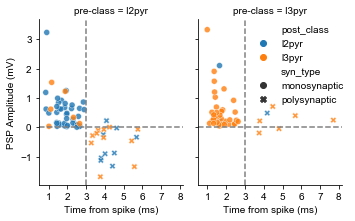

In [14]:
g = sns.FacetGrid(data=l23, col='pre_class', height=3, aspect=0.8, legend_out=True)
g.map_dataframe(sns.scatterplot, x='latency', y='psp_amplitude', hue='post_class', style='syn_type', alpha=0.8)
legend = g.add_legend(loc='upper left', bbox_to_anchor=(0.55, 0.95))
g.set_titles(col_template="pre-class = {col_name}", y=6)
g.set_xlabels('Time from spike (ms)')
g.set_ylabels('PSP Amplitude (mV)')
_ = [a.axvline(3, color='grey', ls='--') for a in g.axes[0]]
_ = [a.axhline(0, color='grey', ls='--') for a in g.axes[0]]
_ = [a.xaxis.set_major_locator(MultipleLocator(1)) for a in g.axes[0]]


In [15]:
human_copy.groupby('syn_type').describe()[['psp_amplitude', 'latency']]

psp_amplitude                                                    \
                     count      mean       std       min       25%       50%   
syn_type                                                                       
monosynaptic          85.0  0.539991  0.616651  0.000588  0.131972  0.368127   
polysynaptic          32.0 -0.249855  0.686072 -1.688441 -0.599974 -0.203991   

                                 latency                                \
                   75%       max   count      mean       std       min   
syn_type                                                                 
monosynaptic  0.671048  3.324364    85.0  1.796829  0.513133  0.848173   
polysynaptic  0.175511  1.810529    32.0  4.365219  0.925277  3.272102   

                                                      
                   25%       50%       75%       max  
syn_type                                              
monosynaptic  1.438339  1.723740  2.220570  2.892309  
polysynaptic  3.785228  4.053952  4.562765  7.704220

In [16]:
human_copy.groupby(['syn_type', 'pair_class']).describe()[['psp_amplitude', 'latency']]

psp_amplitude                                \
                                 count      mean       std       min   
syn_type     pair_class                                                
monosynaptic l2pyr→l2pyr          40.0  0.500604  0.565106  0.000588   
             l2pyr→l3pyr           6.0  0.642788  0.609618  0.030450   
             l3pyr→l2pyr           2.0  1.138488  1.359736  0.177010   
             l3pyr→l3pyr          36.0  0.537496  0.652821  0.039972   
             l5pyr→l5pyr           1.0  0.391522       NaN  0.391522   
polysynaptic l2pyr→l2pyr           9.0 -0.632270  0.544043 -1.327798   
             l2pyr→l3pyr          11.0 -0.466915  0.551175 -1.688441   
             l3pyr→l2pyr           1.0  0.482034       NaN  0.482034   
             l3pyr→l3pyr           6.0  0.217539  0.320701 -0.196832   
             l4pyr→l4pyr           3.0  0.206333  1.402500 -0.787918   
             l5pyr→l5pyr           2.0  0.212431  0.070070  0.162884   

                                                                 latency  \
                               25%       50%       75%       max   count   
syn_type     pair_class                                                    
monosynaptic l2pyr→l2pyr  0.089223  0.454287  0.679821  3.229483    40.0   
             l2pyr→l3pyr  0.176970  0.476094  1.070740  1.527870     6.0   
             l3pyr→l2pyr  0.657749  1.138488  1.619227  2.099967     2.0   
             l3pyr→l3pyr  0.134012  0.306745  0.554748  3.324364    36.0   
             l5pyr→l5pyr  0.391522  0.391522  0.391522  0.391522     1.0   
polysynaptic l2pyr→l2pyr -1.047446 -0.880424 -0.249194  0.222640     9.0   
             l2pyr→l3pyr -0.501685 -0.284976 -0.090043 -0.000075    11.0   
             l3pyr→l2pyr  0.482034  0.482034  0.482034  0.482034     1.0   
             l3pyr→l3pyr  0.014606  0.226908  0.355731  0.705738     6.0   
             l4pyr→l4pyr -0.595764 -0.403611  0.703459  1.810529     3.0   
             l5pyr→l5pyr  0.187657  0.212431  0.237204  0.261977     2.0   

                                                                            \
                              mean       std       min       25%       50%   
syn_type     pair_class                                                      
monosynaptic l2pyr→l2pyr  1.910285  0.548311  0.848173  1.515906  1.908994   
             l2pyr→l3pyr  1.693418  0.696729  1.017222  1.128129  1.524267   
             l3pyr→l2pyr  1.682318  0.058579  1.640896  1.661607  1.682318   
             l3pyr→l3pyr  1.708280  0.441536  0.988053  1.361103  1.626978   
             l5pyr→l5pyr  1.295844       NaN  1.295844  1.295844  1.295844   
polysynaptic l2pyr→l2pyr  4.312301  0.598845  3.782137  3.916850  4.084731   
             l2pyr→l3pyr  4.222092  0.919194  3.272102  3.602358  3.929761   
             l3pyr→l2pyr  4.182047       NaN  4.182047  4.182047  4.182047   
             l3pyr→l3pyr  5.034683  1.490601  3.751852  3.958600  4.643053   
             l4pyr→l4pyr  4.216277  0.282780  4.023691  4.053952  4.084213   
             l5pyr→l5pyr  3.697147  0.142834  3.596148  3.646648  3.697147   

                                              
                               75%       max  
syn_type     pair_class                       
monosynaptic l2pyr→l2pyr  2.331682  2.892309  
             l2pyr→l3pyr  2.215861  2.652276  
             l3pyr→l2pyr  1.703029  1.723740  
             l3pyr→l3pyr  1.911335  2.632699  
             l5pyr→l5pyr  1.295844  1.295844  
polysynaptic l2pyr→l2pyr  4.501868  5.684055  
             l2pyr→l3pyr  4.835242  5.755024  
             l3pyr→l2pyr  4.182047  4.182047  
             l3pyr→l3pyr  5.462366  7.704220  
             l4pyr→l4pyr  4.312571  4.540929  
             l5pyr→l5pyr  3.747646  3.798146

In [17]:
from scipy.stats import mannwhitneyu

l2_dipsp_latency = human_copy[(human_copy['syn_type']=='polysynaptic') & (human_copy['pair_class']=='l2pyr→l2pyr')]['latency'].to_numpy()
l23_dipsp_latency = human_copy[(human_copy['syn_type']=='polysynaptic') & (human_copy['pair_class']=='l2pyr→l3pyr')]['latency'].to_numpy()
mw_stat, latency_pval = mannwhitneyu(l2_dipsp_latency, l23_dipsp_latency)

print('Recurrent L2 dIPSP median latency: %0.2fms' % np.median(l2_dipsp_latency))
print('L2->L3 dIPSP median latency: %0.2fms' % np.median(l23_dipsp_latency))
print('Recurrent L2 vs L2->L3 dIPSP latency: %0.2e' % latency_pval)


l2_dipsp_amp = human_copy[(human_copy['syn_type']=='polysynaptic') & (human_copy['pair_class']=='l2pyr→l2pyr')]['psp_amplitude'].to_numpy()
l23_dipsp_amp = human_copy[(human_copy['syn_type']=='polysynaptic') & (human_copy['pair_class']=='l2pyr→l3pyr')]['psp_amplitude'].to_numpy()
mw_stat, amp_pval = mannwhitneyu(l2_dipsp_amp, l23_dipsp_amp)

print('Recurrent L2 dIPSP median amp: %0.2fmV' % np.median(l2_dipsp_amp))
print('L2->L3 dIPSP median amp: %0.2fmV' % np.median(l23_dipsp_amp))
print('Recurrent L2 vs L2->L3 dIPSP amp: %0.2e' % amp_pval)

Recurrent L2 dIPSP median latency: 4.08ms
L2->L3 dIPSP median latency: 3.93ms
Recurrent L2 vs L2->L3 dIPSP latency: 1.62e-01
Recurrent L2 dIPSP median amp: -0.88mV
L2->L3 dIPSP median amp: -0.28mV
Recurrent L2 vs L2->L3 dIPSP amp: 2.97e-01


# compose figure

In [94]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}
polysyn_pos = np.array((245,360))
figure_spec = [
    {'figure': fig_a_new, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts, 'scale':0.9},
    {'figure': fig_induction_recovery, 'pos': (0, 315), 'label': 'C', 'label_opts': label_opts, 'scale':0.9},
    {'figure': fig_umap, 'pos': (0, 620), 'label': 'E', 'label_opts': label_opts},
    
    {'figure': fig_b, 'pos': (325, 20), 'label': 'B', 'label_opts': label_opts, 'scale':0.9},
    {'figure': trace_fig, 'pos': polysyn_pos+(0, 20), 'label': 'D', 'label_opts': label_opts},
    {'figure': g.fig, 'pos': polysyn_pos+(130, 10), 'label': '', 'label_opts': label_opts},
#     {'figure': poly_fig, 'pos': (270, 360), 'label': 'D', 'label_opts': label_opts, },
#     {'figure': L2_fig, 'pos': (41+270, 135+360), 'label': '', 'label_opts': label_opts},
#     {'figure': L3_fig, 'pos': (310+320, 135+360), 'label': '', 'label_opts': label_opts},
    {'figure': fig_ephys_traces, 'pos': (233, 620), 'label': 'F', 'label_opts': label_opts, 'scale':0.8},
    {'figure': fig_e_r, 'pos': (233-5, 700), 'label': '', 'label_opts': label_opts, 'scale':0.9},
    {'figure': fig_psp_train_example, 'pos': (398, 620), 'label': 'G', 'label_opts': label_opts, 'scale':0.9},
    {'figure': fig_f_horiz, 'pos': (398, 620+145), 'label': '', 'label_opts': label_opts, 'scale':0.9},
]
filename='final_svg/figure_05_human.svg'
nb.compose_svg_figure(figure_spec, size=('7.5in', '10.5in'), filename=filename, display=True)

In [95]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}
e_width = 180
e_y = 690
figure_spec = [
    {'figure': supp_sigma, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts, 'scale':0.9},
    {'figure': supp_matrix, 'pos': (0, 140), 'label': '', 'label_opts': label_opts, 'scale':0.75},
    {'figure': supp_matrices, 'pos': (330, 20), 'label': 'B', 'label_opts': label_opts, 'scale':0.9},
    {'figure': supp_swarms, 'pos': (0, 400), 'label': 'C', 'label_opts': label_opts, 'scale':1},
    {'figure': supp_human_post_types, 'pos': (0, e_y), 'label': 'D', 'label_opts': label_opts},
    {'figure': supp_mouse_post_types, 'pos': (e_width, e_y), 'label': '', 'label_opts': label_opts},
    {'figure': supp_depth_post, 'pos': (2*e_width, e_y), 'label': 'E', 'label_opts': label_opts},
    {'figure': supp_updown_post, 'pos': (3*e_width, e_y), 'label': '', 'label_opts': label_opts},
]

filename='final_svg/figure_s07_human.svg'
nb.compose_svg_figure(figure_spec, size=('7.5in', '10.5in'), filename=filename, display=True)